---
# **0. LIBRARIES & DATA IMPORT**
---

In [149]:
# Main libraries imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Machine learning models import
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier


# Other tools import
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import TomekLinks

In [2]:
# Original df import
original_df = pd.read_csv(r"../Data/TAIPEI_diabetes.csv")

# Creation of a deep copy of the original df
original_raw_df = original_df.copy()

### **Custom functions used throughout the notebook**

In [3]:
# A function that allows to check if the data points data types corresponds to their columns' data type
def dtype_per_column(df):
    for col in df.columns:
        print(f"{col}:")
        dtype_count = {}

        for i in df[col]:
            dtype_name = type(i).__name__
            if dtype_name in dtype_count:
                dtype_count[dtype_name] = dtype_count[dtype_name] + 1
            else:
                dtype_count[dtype_name] = 1

        for dtype_name in dtype_count:
            print(f"{dtype_name}: {str(dtype_count[dtype_name])}")
            print("\n")

# A function that allows to generate and compare descriptive statistics for a specific column across multiple dataframes
def compare_statistics_per_col(dataframes, dataframes_names, column):
    descriptive_statistics = []
    
    for df in dataframes:
        statistics = df[column].describe()
        descriptive_statistics.append(statistics)
    
    result = pd.concat(descriptive_statistics, axis = 1, keys = dataframes_names)

    print("---" * 10)
    print(f"Comparison of descriptive statistics for \x1B[4m{column}\x1B[0m:")
    print("---" * 10)
    return result

# A function that allows to generate and compare histograms for a specific column across multiple dataframes
def compare_histograms_per_col(dataframes, dataframes_names, column):

    n = len(dataframes)
    fig, axes = plt.subplots(ncols = n, nrows = 1, figsize = (5 * n, 4))
    
    for i in range(n):
        ax = axes[i]
        df = dataframes[i]
        name = dataframes_names[i]
        sns.histplot(data = df, x = column, ax = ax, multiple = "stack", kde = True)
        ax.set_title(f"{name}")
    
    print("---" * 10)
    print(f"Comparison of data distributions for \x1B[4m{column}\x1B[0m:")
    print("---" * 10)
    
    plt.tight_layout()
    plt.show()


# A function that allows to check of the top 10 most frequent values per column in a dataframe
def top_10_frequent_values(df):
    for col in df:
        print(f"Top 10 most frequent values for \x1B[4m{col}\x1B[0m::")
        print(df[col].value_counts().head(10))
        print("\n")

# A function that allow to check of duplicated data points per column
def duplicate_values_per_column(df):
    for col in df.columns:
        print(f"{col}: {df[col].duplicated().sum()}")

# A function that generates heat map from two difference columns of the dataset. 
def heatmap_per_col(dataframes,dataframes_names, column0, column1):
    n = len(dataframes)

    fig, axes = plt.subplots(ncols = n, nrows = 1, figsize = (5 * n, 4))
    for i in range(n):
        name = dataframes_names[i]
        sns.kdeplot(x = dataframes[i][column0], y = dataframes[i][column1], fill = True, cmap = "hot", ax = axes[i])

        axes[i].set_title(f"{column0} vs. {column1}: {name} group")
        axes[i].set_xlabel(f"{column0}")
        axes[i].set_ylabel(f"{column1}")
            
    plt.tight_layout()

# A function that aggregates the main performance metrics chosen for the project
def model_performance_metrics(y_true, y_pred, y_pima_true, y_pima_pred):
    test_report = classification_report(y_true, y_pred)
    test_matrix = confusion_matrix(y_true, y_pred)
    test_rocauc = roc_auc_score(y_true, y_pred)

    pima_report = classification_report(y_pima_true, y_pima_pred)
    pima_matrix = confusion_matrix(y_pima_true, y_pima_pred)
    pima_rocauc = roc_auc_score(y_pima_true, y_pima_pred)

    print("===" * 20)
    print("Classification Report - test dataset:")
    print("===" * 20)
    print(test_report)
    print("\n")
    print("===" * 20)
    print("Classification Report - PIMA Indian dataset:")
    print("===" * 20)
    print(pima_report)
    print("\n")
    print("===" * 20)
    print(f"AUC-ROC score - test dataset: {test_rocauc:.5f}")
    print("===" * 20)
    print("\n")
    print("===" * 20)
    print(f"AUC-ROC score - PIMA Indian dataset: {pima_rocauc:.5f}")
    print("===" * 20)
    print("\n")
    print("===" * 20)
    print("Confusion Matrix - test dataset:")
    print("===" * 20)
    print(test_matrix)
    print("\n")
    print("===" * 20)
    print("Confusion Matrix - PIMA Indian dataset:")
    print("===" * 20)
    print(pima_matrix)

# A function that creates a histplot for outliers
def plot_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_df = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data = outlier_df, x=col, hue="Diabetic", multiple = "dodge")
    plt.title(f"{col} Outliers")
    plt.xlabel(col)
    plt.ylabel("Outliers sum")
    plt.show()

# A function that isolates the outliers based on IQR method and returns a dataframe
def isolate_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

---
# **1. INITIAL DATA OVERVIEW**
---

**This part is dedicated to get a general understanding of the data available on hand and identification of the following:**
* general shape of the dataframe;
* features available for the prediction of our target variable;
* detecting NULL data points;
* columns' data types;
* check if the data point respects the data type of the column;
* duplicate values.

In [4]:
# Df sizing
original_df.shape

(15000, 10)

In [5]:
# Quick look at the first values of the df on hand
original_df.head(10)

PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
0    1354778            0            171                      80   
1    1147438            8             92                      93   
2    1640031            7            115                      47   
3    1883350            9            103                      78   
4    1424119            1             85                      59   
5    1619297            0             82                      92   
6    1660149            0            133                      47   
7    1458769            0             67                      87   
8    1201647            8             80                      95   
9    1403912            1             72                      31   

   TricepsThickness  SerumInsulin        BMI  DiabetesPedigree  Age  Diabetic  
0                34            23  43.509726          1.213191   21         0  
1                47            36  21.240576          0.158365   23         0  
2                52            35  41.511523          0.079019   23         0  
3                25           304  29.582192          1.282870   43         1  
4                27            35  42.604536          0.549542   22         0  
5                 9           253  19.724160          0.103424   26         0  
6                19           227  21.941357          0.174160   21         0  
7                43            36  18.277723          0.236165   26         0  
8                33            24  26.624929          0.443947   53         1  
9                40            42  36.889576          0.103944   26         0

In [6]:
# Quick look at the last values of the df on hand
original_df.tail(10)

PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
14990    1220763            5            169                      83   
14991    1603490            0            114                      53   
14992    1202654            3             48                      60   
14993    1165919            1            128                      59   
14994    1453189            0             72                      99   
14995    1490300           10             65                      60   
14996    1744410            2             73                      66   
14997    1742742            0             93                      89   
14998    1099353            0            132                      98   
14999    1386396            3            114                      65   

       TricepsThickness  SerumInsulin        BMI  DiabetesPedigree  Age  \
14990                31            60  49.004793          0.187397   53   
14991                34            40  44.760534          0.143487   23   
14992                24            81  29.417154          0.159605   42   
14993                21           182  19.766514          0.167280   53   
14994                32            32  20.932808          0.545038   22   
14995                46           177  33.512468          0.148327   41   
14996                27           168  30.132636          0.862252   38   
14997                43            57  18.690683          0.427049   24   
14998                18           161  19.791645          0.302257   23   
14999                47           512  36.215437          0.147363   34   

       Diabetic  
14990         1  
14991         0  
14992         1  
14993         0  
14994         0  
14995         1  
14996         1  
14997         0  
14998         0  
14999         1

In [7]:
# First check of the NULL data points inside the columns and their data types
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


In [8]:
# Second check of the NULL values
original_df.isna().sum()

PatientID                 0
Pregnancies               0
PlasmaGlucose             0
DiastolicBloodPressure    0
TricepsThickness          0
SerumInsulin              0
BMI                       0
DiabetesPedigree          0
Age                       0
Diabetic                  0
dtype: int64

In [11]:
# Check of the duplicated rows
duplicate_rows = original_df.duplicated().sum()

print(f"Total duplicated rows: {duplicate_rows}.")

Total duplicated rows: 0.


In [9]:
# Check of duplicated data points per column
duplicate_values_per_column(original_df)

PatientID: 105
Pregnancies: 14985
PlasmaGlucose: 14851
DiastolicBloodPressure: 14910
TricepsThickness: 14931
SerumInsulin: 14337
BMI: 0
DiabetesPedigree: 1
Age: 14944
Diabetic: 14998


In [10]:
# Statistical description of the original df
original_df.describe()

PatientID   Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
count  1.500000e+04  15000.000000   15000.000000            15000.000000   
mean   1.502922e+06      3.224533     107.856867               71.220667   
std    2.892534e+05      3.391020      31.981975               16.758716   
min    1.000038e+06      0.000000      44.000000               24.000000   
25%    1.252866e+06      0.000000      84.000000               58.000000   
50%    1.505508e+06      2.000000     104.000000               72.000000   
75%    1.755205e+06      6.000000     129.000000               85.000000   
max    1.999997e+06     14.000000     192.000000              117.000000   

       TricepsThickness  SerumInsulin           BMI  DiabetesPedigree  \
count      15000.000000  15000.000000  15000.000000      15000.000000   
mean          28.814000    137.852133     31.509646          0.398968   
std           14.555716    133.068252      9.759000          0.377944   
min            7.000000     14.000000     18.200512          0.078044   
25%           15.000000     39.000000     21.259887          0.137743   
50%           31.000000     83.000000     31.767940          0.200297   
75%           41.000000    195.000000     39.259692          0.616285   
max           93.000000    799.000000     56.034628          2.301594   

                Age      Diabetic  
count  15000.000000  15000.000000  
mean      30.137733      0.333333  
std       12.089703      0.471420  
min       21.000000      0.000000  
25%       22.000000      0.000000  
50%       24.000000      0.000000  
75%       35.000000      1.000000  
max       77.000000      1.000000

In [18]:
# Count of the outcome values present in the original dataset
target_proportion = original_df["Diabetic"].value_counts()
print(target_proportion)

Diabetic
0    10000
1     5000
Name: count, dtype: int64


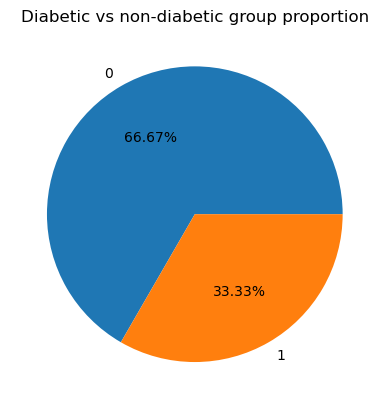

In [12]:
# Proportion of the target variable records
diabetic_split = original_df["Diabetic"].value_counts()
plt.pie(diabetic_split, labels = diabetic_split.index, autopct = "%1.2f%%")
plt.title("Diabetic vs non-diabetic group proportion")
plt.show()

### **INITIAL DATA OVERVIEW OBSERVATIONS**

* The studied dataset consists of 15 000 records in total.

* It has 10 columns, with all of them being of a numerical data type (8x int64 and 2x float64).

* The features are of numeric nature, both continuous and discrete. The target is a categorical, binary data type.

* All the data points match the expected data types for their respective columns. Based on the preliminary notes documentation, these data types seem correct given the features. Therefore, there is no need for type casting in order to normalize the data types.

* The dataset contains no NULL values or duplicate rows, allowing us to explore it further during the EDA phase, without additional manipulations at this stage.

* 2/3 of the dataset contains non-diabetic patients records (target variable), which may lead to a class imbalance, where a machine learning model is better at predicting the non-diabetic patients, rather than the diabetic ones.

* An interesting observation is that 105 PatientID values are duplicated, suggesting that some patients may have undergone multiple check-ups. We have to verify it, as knowing if they are unique or not will influence the choice of the train and test data split technique during the models training phase.

---
# **3. EXPLORATORY DATA ANALYSIS (EDA)**
---

## **3.1 Closer look at the repeated PatientID**

**This part is dedicated to:**
* take a closer look at the repeated PatientID to comprehend if some patient underwent multiple medical checkups;
* decide on the treatment of the repeated PatientID values: keep, reject or adjust them.

In [13]:
# Creation of a df with only repeated patients, ordered by the PatientID and the original df index
df_repeated_patients = original_df[original_df.duplicated(subset = "PatientID", keep = False)].sort_values(by = "PatientID", ascending = True, kind = "mergesort")

# Creation of an additional column with the number of occurences for doubled patients, incremented according to the original df index
df_repeated_patients["Occurence"] = df_repeated_patients.groupby("PatientID").cumcount() + 1

df_repeated_patients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 3350 to 10750
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               210 non-null    int64  
 1   Pregnancies             210 non-null    int64  
 2   PlasmaGlucose           210 non-null    int64  
 3   DiastolicBloodPressure  210 non-null    int64  
 4   TricepsThickness        210 non-null    int64  
 5   SerumInsulin            210 non-null    int64  
 6   BMI                     210 non-null    float64
 7   DiabetesPedigree        210 non-null    float64
 8   Age                     210 non-null    int64  
 9   Diabetic                210 non-null    int64  
 10  Occurence               210 non-null    int64  
dtypes: float64(2), int64(9)
memory usage: 19.7 KB


In [14]:
# Creation of a df without repeated patients
df_removed_duplicates = original_df[~original_df["PatientID"].isin(df_repeated_patients["PatientID"])]
df_removed_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14790 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               14790 non-null  int64  
 1   Pregnancies             14790 non-null  int64  
 2   PlasmaGlucose           14790 non-null  int64  
 3   DiastolicBloodPressure  14790 non-null  int64  
 4   TricepsThickness        14790 non-null  int64  
 5   SerumInsulin            14790 non-null  int64  
 6   BMI                     14790 non-null  float64
 7   DiabetesPedigree        14790 non-null  float64
 8   Age                     14790 non-null  int64  
 9   Diabetic                14790 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.2 MB


In [15]:
# Statistical description of the original dataset
original_df.describe()

PatientID   Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
count  1.500000e+04  15000.000000   15000.000000            15000.000000   
mean   1.502922e+06      3.224533     107.856867               71.220667   
std    2.892534e+05      3.391020      31.981975               16.758716   
min    1.000038e+06      0.000000      44.000000               24.000000   
25%    1.252866e+06      0.000000      84.000000               58.000000   
50%    1.505508e+06      2.000000     104.000000               72.000000   
75%    1.755205e+06      6.000000     129.000000               85.000000   
max    1.999997e+06     14.000000     192.000000              117.000000   

       TricepsThickness  SerumInsulin           BMI  DiabetesPedigree  \
count      15000.000000  15000.000000  15000.000000      15000.000000   
mean          28.814000    137.852133     31.509646          0.398968   
std           14.555716    133.068252      9.759000          0.377944   
min            7.000000     14.000000     18.200512          0.078044   
25%           15.000000     39.000000     21.259887          0.137743   
50%           31.000000     83.000000     31.767940          0.200297   
75%           41.000000    195.000000     39.259692          0.616285   
max           93.000000    799.000000     56.034628          2.301594   

                Age      Diabetic  
count  15000.000000  15000.000000  
mean      30.137733      0.333333  
std       12.089703      0.471420  
min       21.000000      0.000000  
25%       22.000000      0.000000  
50%       24.000000      0.000000  
75%       35.000000      1.000000  
max       77.000000      1.000000

In [16]:
# Statistical description of the repeated patients
df_repeated_patients.describe()

PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
count  2.100000e+02   210.000000     210.000000              210.000000   
mean   1.515977e+06     3.080952     107.847619               69.547619   
std    2.788603e+05     3.360069      30.199744               16.858548   
min    1.015338e+06     0.000000      47.000000               24.000000   
25%    1.267578e+06     0.000000      87.000000               56.250000   
50%    1.545001e+06     1.500000     105.000000               67.000000   
75%    1.735297e+06     6.000000     127.750000               84.000000   
max    1.998870e+06    14.000000     185.000000              113.000000   

       TricepsThickness  SerumInsulin         BMI  DiabetesPedigree  \
count        210.000000    210.000000  210.000000        210.000000   
mean          30.900000    131.357143   30.563109          0.388672   
std           14.299078    128.511132    9.354205          0.346752   
min            7.000000     14.000000   18.291302          0.079090   
25%           19.000000     35.000000   21.389471          0.146010   
50%           32.000000     78.500000   30.896698          0.200668   
75%           43.750000    188.000000   38.583220          0.640889   
max           73.000000    682.000000   51.326693          2.296062   

              Age    Diabetic   Occurence  
count  210.000000  210.000000  210.000000  
mean    29.790476    0.333333    1.500000  
std     11.290590    0.472531    0.501195  
min     21.000000    0.000000    1.000000  
25%     22.000000    0.000000    1.000000  
50%     24.000000    0.000000    1.500000  
75%     35.750000    1.000000    2.000000  
max     71.000000    1.000000    2.000000

In [17]:
# Detailed overview of the repeated patients
print(df_repeated_patients.sort_values(by = ["PatientID", "Occurence", "DiabetesPedigree"]).to_string())

       PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  SerumInsulin        BMI  DiabetesPedigree  Age  Diabetic  Occurence
3350     1015338           10            104                      59                57           259  29.268008          0.820120   21         1          1
4867     1015338            1             76                      48                44            37  21.280339          0.079090   22         0          2
2736     1033352            0            157                      97                34           221  36.263025          0.182434   60         0          1
2799     1033352            9            111                     100                 8            79  31.445866          0.283731   38         1          2
2968     1054588            0            144                      55                10            41  18.662067          0.151034   22         0          1
12419    1054588            3             50                    

In [18]:
# Detailed look at the top 10 most occuring values per column: repeated patients df
top_10_frequent_values(df_repeated_patients)

Top 10 most frequent values for PatientID::
PatientID
1015338    2
1033352    2
1054588    2
1063170    2
1079564    2
1099669    2
1104393    2
1109455    2
1127499    2
1134543    2
Name: count, dtype: int64


Top 10 most frequent values for Pregnancies::
Pregnancies
0    68
1    37
7    18
3    17
2    14
6    14
8    10
5    10
9     8
4     5
Name: count, dtype: int64


Top 10 most frequent values for PlasmaGlucose::
PlasmaGlucose
92     6
96     6
97     6
144    5
72     5
126    5
118    5
106    5
104    5
121    4
Name: count, dtype: int64


Top 10 most frequent values for DiastolicBloodPressure::
DiastolicBloodPressure
80    8
66    7
59    7
87    6
62    6
81    6
55    6
65    6
67    6
64    6
Name: count, dtype: int64


Top 10 most frequent values for TricepsThickness::
TricepsThickness
44    13
31    13
35    13
45    10
32     9
12     8
15     7
10     7
22     6
46     6
Name: count, dtype: int64


Top 10 most frequent values for SerumInsulin::
SerumInsulin
35    5


#### **Repeated PatientID observations**

* According to preliminary notes provided to us before starting the project, data collection occurred in two periods: 2018–2020 and 2021–2022, spanning exactly five years. However, for some repeated patients, the age gap far exceeds this threshold. For instance, Patient's 1033352 first record lists their age as 60, while the second records them as 38.

* Additionally, inconsistencies in patients' pregnancy history raise concerns about data accuracy. For example, Patient 1015338 is recorded with 10 pregnancies at age 21, yet a subsequent record at age 22 indicates 0 pregnancies. While high pregnancy counts may be an outcome of the cultural contexts of the region where the data was collected from (Taipei, Taiwan), same Patient IDs paired with unreasonable age difference values or pregnancies count suggest errors in data entry.

* However, none of the repeated patients share the same Diabetes Pedigree, which is a function that scores the probability of diabetes based on family history. Once it is calculated, it stays fixed for an individual, unless new & important family information is discovered, in which case it might be recalculated. Upon checking the difference between two values for the same individuals, none of them have the same value. Therefore, most probably the repeated patient id is just a data entry error, and they are not the same person, which explains suspicious differences with age and pregnancies.

#### **Repeated PatientID data implications**:

* A closer examination of repeated patients data rejects the initial hypothesis that the same individuals might have undergone a second medical check-up. They are most likely different people. As such, the repeated PatientID individuals will be kept in the dataset for further analysis.

---
## **3.2 Univariate & bivariate analysis**

**This part is dedicated to:**
* explore the data more in detail, by examining each column individually and their relationship to the target value;
* explore the relationships between the features other than the target;
* understand if the data on hand is better at predicting the diabetic or non-diabetic outcome;
* understand if we can and should develop additional features.

In [19]:
# Division of the dataset into diabetic and non-diabetic dataframes
df_non_diabetic = original_df[original_df["Diabetic"] == 0]
df_diabetic = original_df[original_df["Diabetic"] == 1]

In [20]:
# Statistics summary of the dataset without repeated patients
original_df.describe()

PatientID   Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
count  1.500000e+04  15000.000000   15000.000000            15000.000000   
mean   1.502922e+06      3.224533     107.856867               71.220667   
std    2.892534e+05      3.391020      31.981975               16.758716   
min    1.000038e+06      0.000000      44.000000               24.000000   
25%    1.252866e+06      0.000000      84.000000               58.000000   
50%    1.505508e+06      2.000000     104.000000               72.000000   
75%    1.755205e+06      6.000000     129.000000               85.000000   
max    1.999997e+06     14.000000     192.000000              117.000000   

       TricepsThickness  SerumInsulin           BMI  DiabetesPedigree  \
count      15000.000000  15000.000000  15000.000000      15000.000000   
mean          28.814000    137.852133     31.509646          0.398968   
std           14.555716    133.068252      9.759000          0.377944   
min            7.000000     14.000000     18.200512          0.078044   
25%           15.000000     39.000000     21.259887          0.137743   
50%           31.000000     83.000000     31.767940          0.200297   
75%           41.000000    195.000000     39.259692          0.616285   
max           93.000000    799.000000     56.034628          2.301594   

                Age      Diabetic  
count  15000.000000  15000.000000  
mean      30.137733      0.333333  
std       12.089703      0.471420  
min       21.000000      0.000000  
25%       22.000000      0.000000  
50%       24.000000      0.000000  
75%       35.000000      1.000000  
max       77.000000      1.000000

In [21]:
# Statistics summary of the number of pregnancies per dataset
compare_statistics_per_col([original_df, df_non_diabetic, df_diabetic], ["original_df", "df_non_diabetic", "df_diabetic"], "Pregnancies")

------------------------------
Comparison of descriptive statistics for Pregnancies:
------------------------------


original_df  df_non_diabetic  df_diabetic
count  15000.000000     10000.000000  5000.000000
mean       3.224533         2.247900     5.177800
std        3.391020         3.130531     3.029063
min        0.000000         0.000000     0.000000
25%        0.000000         0.000000     3.000000
50%        2.000000         1.000000     5.000000
75%        6.000000         3.000000     8.000000
max       14.000000        11.000000    14.000000

In [22]:
# Statistics summary of the plasma glucose levels per dataset
compare_statistics_per_col([original_df, df_non_diabetic, df_diabetic], ["original_df", "df_non_diabetic", "df_diabetic"], "PlasmaGlucose")

------------------------------
Comparison of descriptive statistics for PlasmaGlucose:
------------------------------


original_df  df_non_diabetic  df_diabetic
count  15000.000000     10000.000000  5000.000000
mean     107.856867       104.962200   113.646200
std       31.981975        32.076304    30.994844
min       44.000000        44.000000    44.000000
25%       84.000000        80.000000    98.000000
50%      104.000000        96.000000   108.000000
75%      129.000000       128.000000   131.250000
max      192.000000       189.000000   192.000000

In [23]:
# Statistics summary of the diastolic blood pressure levels per dataset
compare_statistics_per_col([original_df, df_non_diabetic, df_diabetic], ["original_df", "df_non_diabetic", "df_diabetic"], "DiastolicBloodPressure")

------------------------------
Comparison of descriptive statistics for DiastolicBloodPressure:
------------------------------


original_df  df_non_diabetic  df_diabetic
count  15000.000000     10000.000000  5000.000000
mean      71.220667        70.138700    73.384600
std       16.758716        17.704926    14.445041
min       24.000000        24.000000    24.000000
25%       58.000000        55.000000    63.000000
50%       72.000000        69.000000    74.000000
75%       85.000000        85.000000    85.000000
max      117.000000       117.000000   109.000000

In [24]:
# Statistics summary of the triceps thickness per dataset
compare_statistics_per_col([original_df, df_non_diabetic, df_diabetic], ["original_df", "df_non_diabetic", "df_diabetic"], "TricepsThickness")

------------------------------
Comparison of descriptive statistics for TricepsThickness:
------------------------------


original_df  df_non_diabetic  df_diabetic
count  15000.000000     10000.000000  5000.000000
mean      28.814000        27.244400    31.953200
std       14.555716        13.906287    15.300269
min        7.000000         7.000000     7.000000
25%       15.000000        12.000000    21.000000
50%       31.000000        31.000000    29.000000
75%       41.000000        39.000000    44.000000
max       93.000000        57.000000    93.000000

In [25]:
# Statistics summary of the serum insulin levels per dataset
compare_statistics_per_col([original_df, df_non_diabetic, df_diabetic], ["original_df", "df_non_diabetic", "df_diabetic"], "SerumInsulin")

------------------------------
Comparison of descriptive statistics for SerumInsulin:
------------------------------


original_df  df_non_diabetic  df_diabetic
count  15000.000000     10000.000000  5000.000000
mean     137.852133       114.576500   184.403400
std      133.068252       116.834954   150.245929
min       14.000000        14.000000    14.000000
25%       39.000000        32.000000    70.000000
50%       83.000000        52.000000   153.000000
75%      195.000000       174.000000   257.000000
max      799.000000       707.000000   799.000000

In [26]:
# Statistics summary of the BMI per dataset
compare_statistics_per_col([original_df, df_non_diabetic, df_diabetic], ["original_df", "df_non_diabetic", "df_diabetic"], "BMI")

------------------------------
Comparison of descriptive statistics for BMI:
------------------------------


original_df  df_non_diabetic  df_diabetic
count  15000.000000     10000.000000  5000.000000
mean      31.509646        30.057052    34.414834
std        9.759000        10.093520     8.325321
min       18.200512        18.200512    18.218614
25%       21.259887        20.624081    28.642144
50%       31.767940        28.323487    33.716060
75%       39.259692        39.123578    39.737780
max       56.034628        51.418626    56.034628

In [27]:
# Statistics summary of the diabetes pedigree per dataset
compare_statistics_per_col([original_df, df_non_diabetic, df_diabetic], ["original_df", "df_non_diabetic", "df_diabetic"], "DiabetesPedigree")

------------------------------
Comparison of descriptive statistics for DiabetesPedigree:
------------------------------


original_df  df_non_diabetic  df_diabetic
count  15000.000000     10000.000000  5000.000000
mean       0.398968         0.353457     0.489990
std        0.377944         0.331053     0.443775
min        0.078044         0.078044     0.078083
25%        0.137743         0.135498     0.143748
50%        0.200297         0.193486     0.222887
75%        0.616285         0.521379     0.774823
max        2.301594         2.215815     2.301594

In [28]:
# Statistics summary of the age per dataset
compare_statistics_per_col([original_df, df_non_diabetic, df_diabetic], ["original_df", "df_non_diabetic", "df_diabetic"], "Age")

------------------------------
Comparison of descriptive statistics for Age:
------------------------------


original_df  df_non_diabetic  df_diabetic
count  15000.000000     10000.000000  5000.000000
mean      30.137733        27.209000    35.995200
std       12.089703         9.928463    13.780332
min       21.000000        21.000000    21.000000
25%       22.000000        22.000000    22.000000
50%       24.000000        24.000000    37.000000
75%       35.000000        26.000000    46.000000
max       77.000000        77.000000    67.000000

#### **Statistical Observations**:

* As we deduced before, we have 1/3 (33%) of patients of the dataset are diabetic. This proportion is way higher than the world's diabetic population proportion - 537 million adults aged 20-79 living with diabetes in 2021 around the world (~6.68% of the whole world population).

* The average age is 30 however the median is 24. It means that in this dataset more aged individuals are less present. The third quartile at 35 means that 25% of the dataset individuals are over 35, leaving more mature women subset at inbalance.

* In accordance with the dataset documentation, baseline blood glucose values (i.e. fasting blood glucose) are not provided in this dataset. However, we do have the values 2 hours after ingestion of the glucose solution. Plasma Glucose World Health Organization classifies the values as follows:
1. < 140 mg/dL (7.8 mmol/L) → Normal
2. 140 - 199 mg/dL (7.8 - 11.0 mmol/L) → Glucose intolerance (prediabetes)
3. ≥ 200 mg/dL (11.1 mmol/L) → Diabetees

* Since the maximum value of plasmaglucose (192) is lower than the one in the WHO standards for diabetes diagnosis, we conclude that the dataset entries used different measure standard to determine the presence of diabetes.


In [29]:
# Quick look at the top 10 most occuring values per column
top_10_frequent_values(original_df)

Top 10 most frequent values for PatientID::
PatientID
1321191    2
1772038    2
1693955    2
1951340    2
1104393    2
1015338    2
1460338    2
1459465    2
1733432    2
1567493    2
Name: count, dtype: int64


Top 10 most frequent values for Pregnancies::
Pregnancies
0    4377
1    2864
3    1219
6    1070
2     939
7     895
9     881
5     687
4     675
8     645
Name: count, dtype: int64


Top 10 most frequent values for PlasmaGlucose::
PlasmaGlucose
97     263
96     240
118    209
95     199
107    199
119    196
93     195
85     194
117    193
114    191
Name: count, dtype: int64


Top 10 most frequent values for DiastolicBloodPressure::
DiastolicBloodPressure
81    445
79    416
78    406
83    404
80    401
86    400
84    394
82    385
60    358
85    354
Name: count, dtype: int64


Top 10 most frequent values for TricepsThickness::
TricepsThickness
11    657
9     593
10    572
45    521
34    517
7     511
8     493
44    488
31    481
35    481
Name: count, dtype: int64


------------------------------
Comparison of data distributions for Pregnancies:
------------------------------


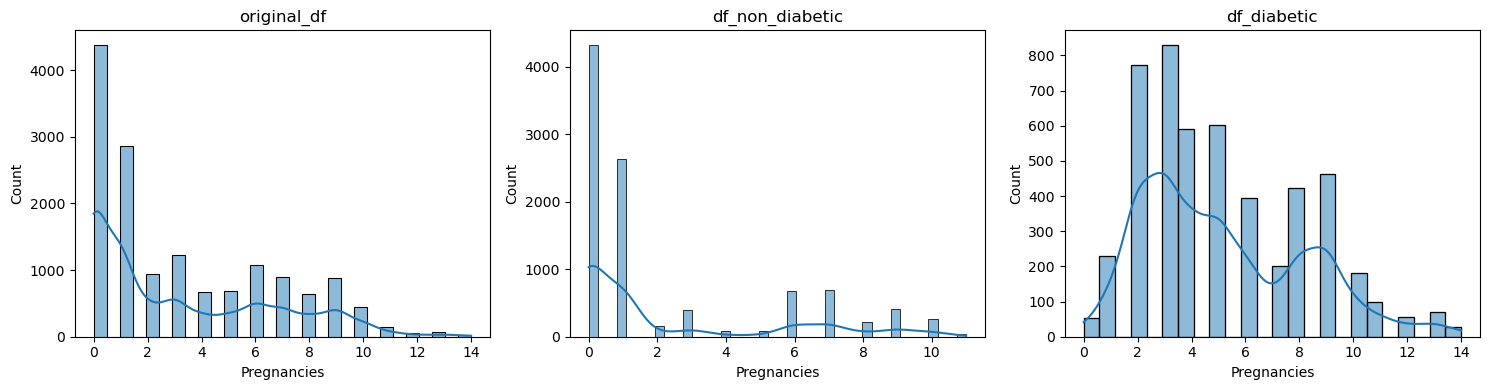

------------------------------
Comparison of data distributions for PlasmaGlucose:
------------------------------


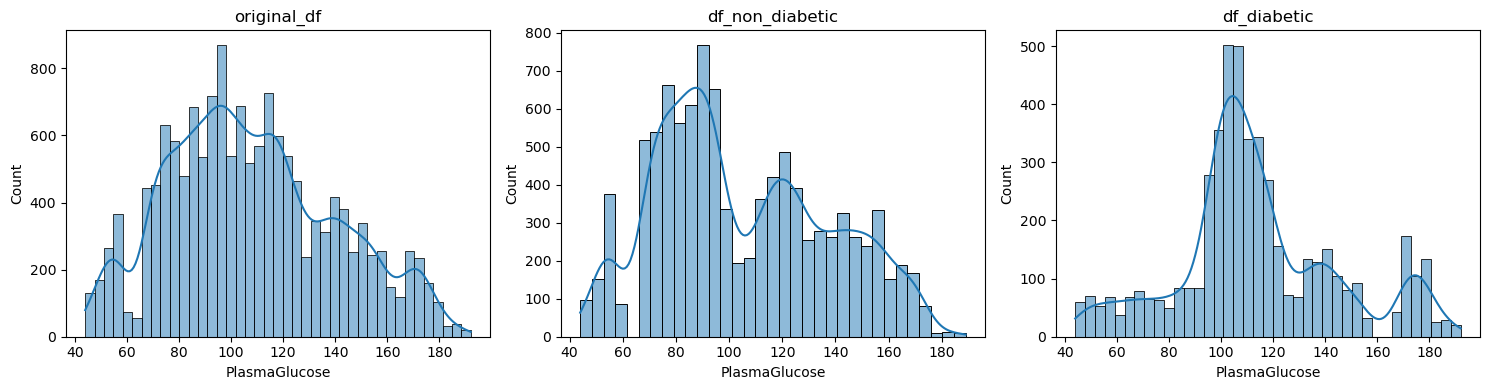

------------------------------
Comparison of data distributions for DiastolicBloodPressure:
------------------------------


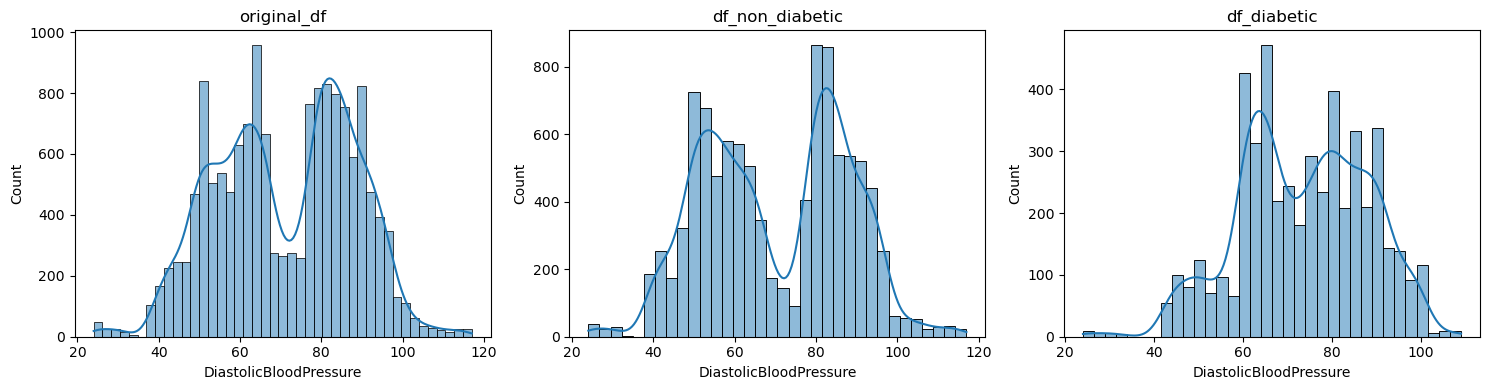

------------------------------
Comparison of data distributions for TricepsThickness:
------------------------------


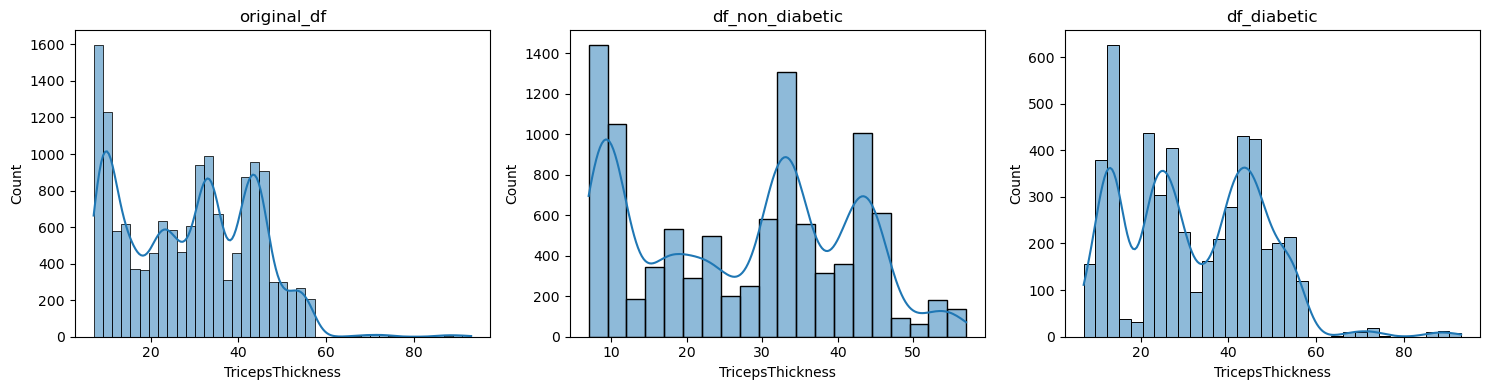

------------------------------
Comparison of data distributions for SerumInsulin:
------------------------------


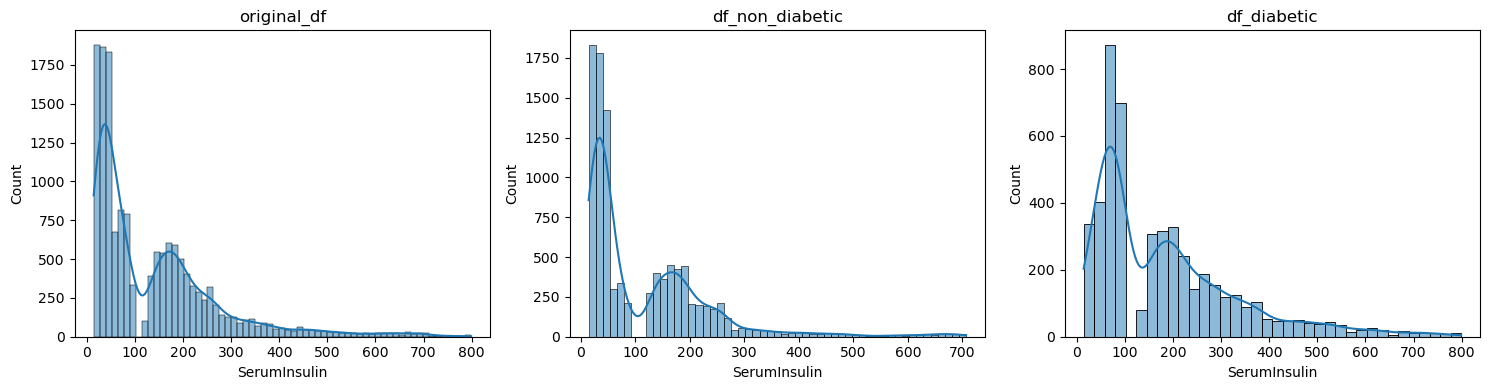

------------------------------
Comparison of data distributions for BMI:
------------------------------


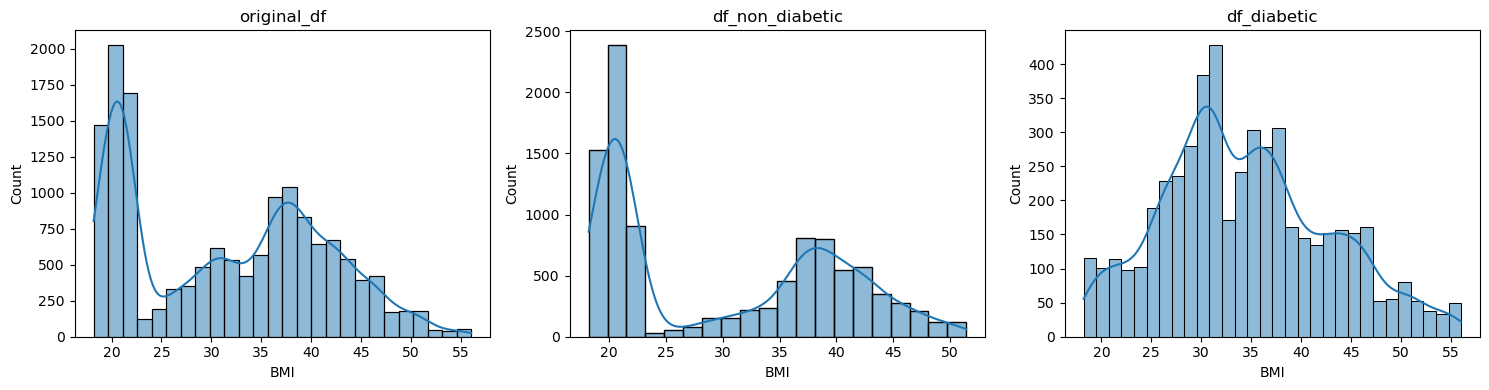

------------------------------
Comparison of data distributions for DiabetesPedigree:
------------------------------


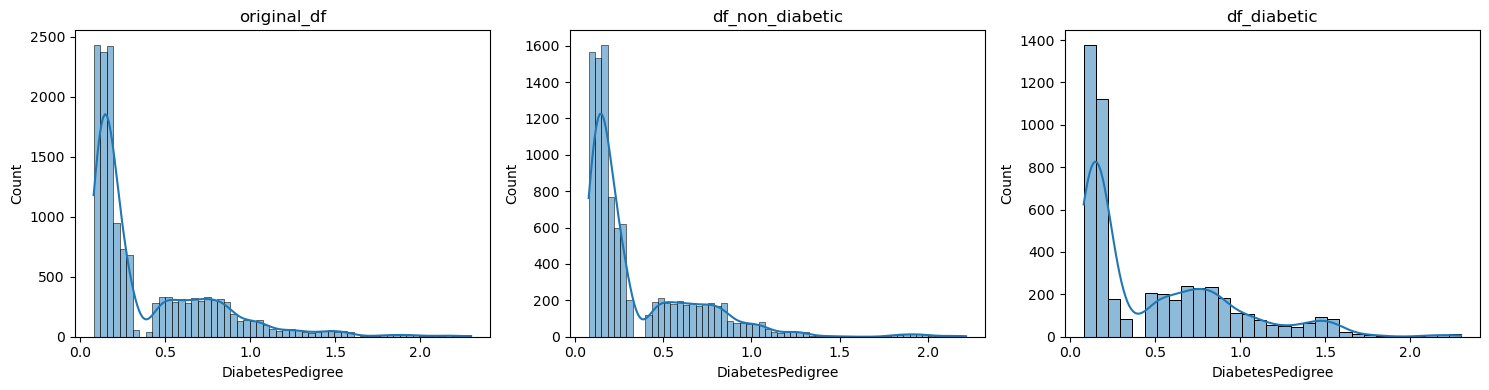

------------------------------
Comparison of data distributions for Age:
------------------------------


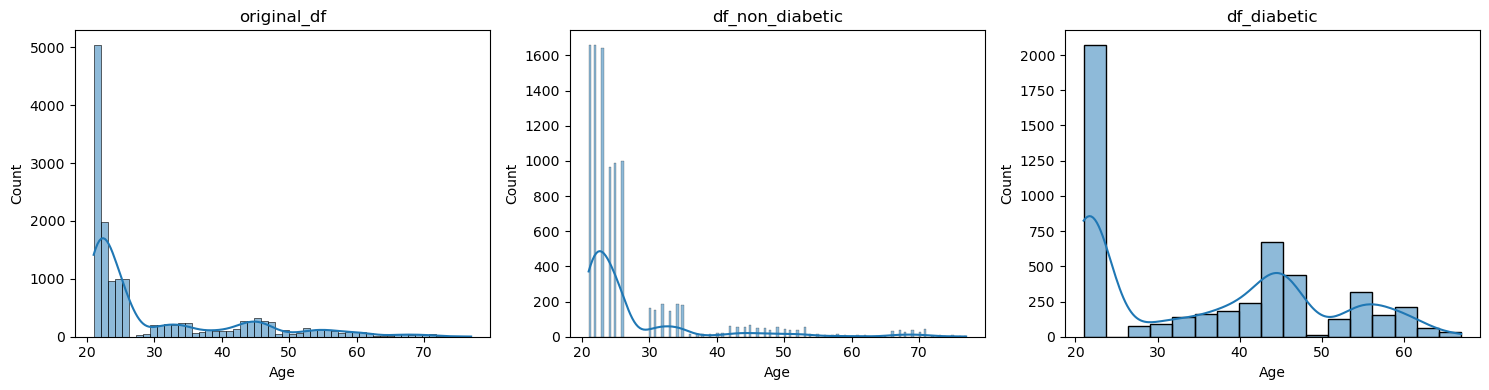

In [30]:
# Comparison of data distributions between the whole dataset, diabetic and non-diabetic subsets
for col in original_df.columns:
    if col != "PatientID" and col!= "Diabetic":
        compare_histograms_per_col([original_df, df_non_diabetic, df_diabetic], ["original_df", "df_non_diabetic", "df_diabetic"], col)

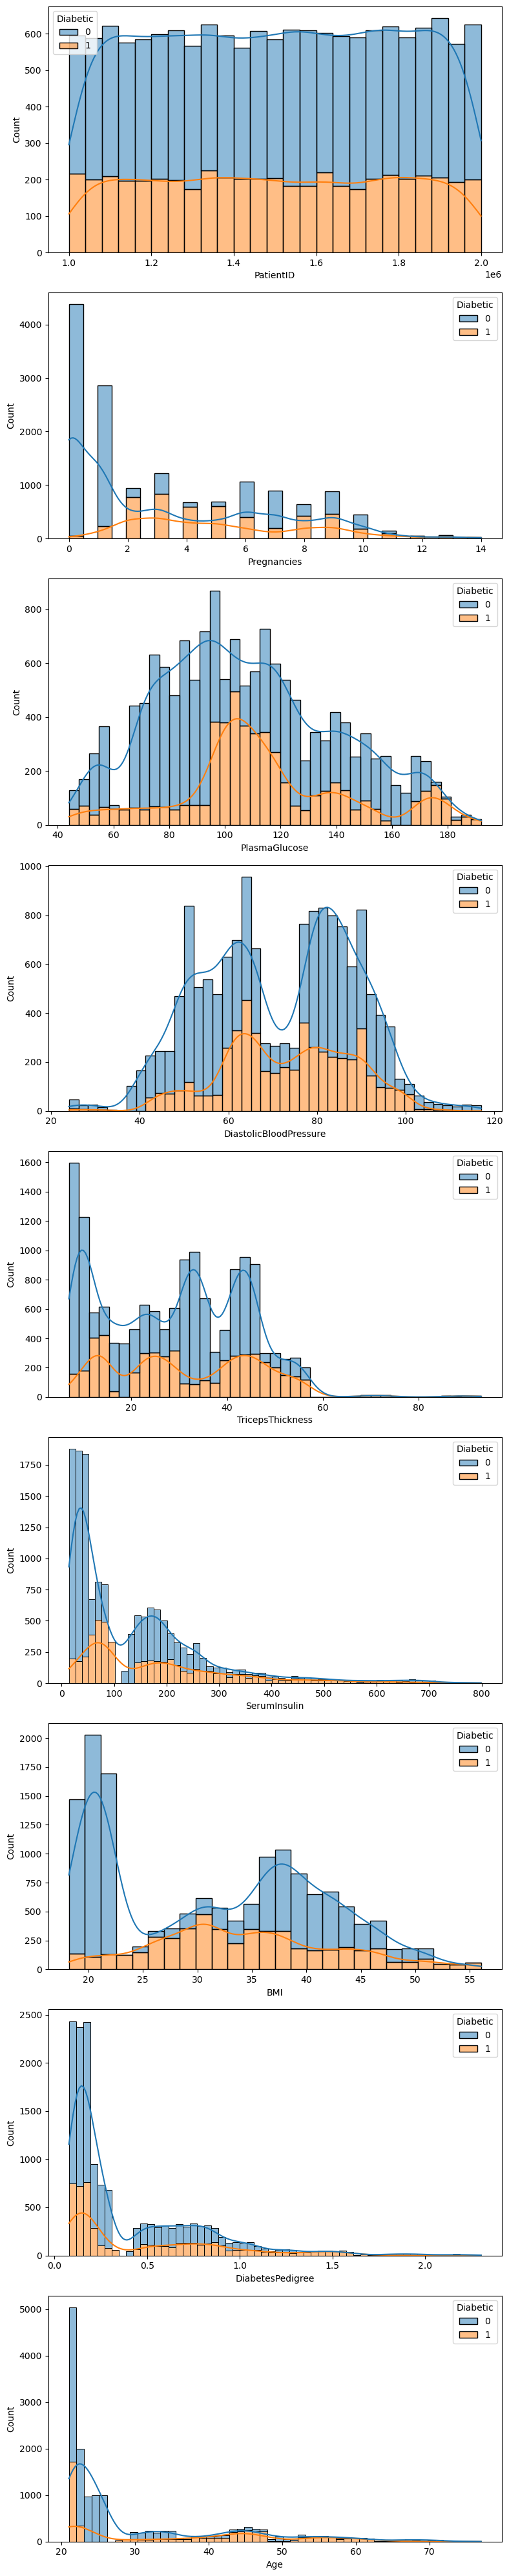

In [29]:
# Comparison of diabetic outcome histograms per column
fig, axes = plt.subplots(nrows = len(original_df.columns)-1, ncols = 1, figsize = (8, 40))

for i, col in enumerate(original_df.columns):
    if col not in ["Diabetic"]:
        sns.histplot(data = original_df, x = col, hue = "Diabetic", multiple="stack", kde = True, ax = axes[i])
        
plt.tight_layout()
plt.show()

#### **Pregnancies data observations**:

* right-skewed data distribution in all three histograms (df, df_non_diabetic, df_diabetic); the tail extends to the right;
* 75% of all patient have had between 0 and 6 pregnancies, whereas the overall range is 0 to 14 pregnancies;
* diabetic group has a higher average pregnancy count (~5.2 vs. ~2.2 for non-diabetic);
* 50% of all diabetic patient have had ≤ 5 pregnancies (vs. 1 for non-diabetics), and 75% has had ≤8 pregnancies (vs. 3 for non-diabetics);

#### **Pregnancies data implications**: 
* **Diabetes risk might increase as the number of pregnancies grows.**


#### **Plasma Glucose data observations**:
* slightly right-skewed for the full sample and non-diabetic group, roughly symetric for the diabetic group;
* 75% of all patient have a concentration between 44 and 129mg/dL, whereas the overall range is 44 to 192mg/dL;
* diabetic group has a higher average rate (~114mg/dL vs. ~105mg/dL for non-diabetic);
* 50% of all diabetic patient have a concentration of 108mg/dL (vs. 96mg/dL for  non-diabetics), and 75% have 131mg/dL (vs. 128mg/dL for non-diabetics);

#### **Plasma Glucose data implications**: 
* **Diabetic group has a slightly higher Plasma Glucose levels** than non-diabetic group (~105mg/dL vs. ~113.7mg/dL).


#### **Diastolic Blood Pressure data observations**:
* roughly bimodal data distribution across 3 data frames; might imply that the data came from two different processes or two population group;
* 75% of all patient have a diastolic blood pressure between 24 and 85mmHg, equal to the overall range;
* diabetic group has a slightly higher average diastolic blood pressure level (~73.4mmHg vs. ~70.1mmHg for non-diabetic);
* 50% of all diabetic patient has diastolic blood pressure level ≤ 74mmHg (vs. 69mmHg for non-diabetics), and 75% of both diabetic and non-diabetic groups is ≤ 85mmHg;
* 4th quartile (max) trend is reversed, where non-diabetic patients have lower diastolic blood pressure level (109mmHg vs. 117mmHg for non_diabetics).

#### **Diastolic Blood Pressure data implications**: 
* **Higher Diastolic Blood Pressure levels might have a slight impact** on the diabetic outcome.
* **A diastolic blood pressure below 30 is a vital emergency** (cardiac arrest, steptic shock, dehydration, massive blood lost, etc.). Patients with these readings might die without immediate medical intervention. Reading this low raises a suspicion of a data collection error.


#### **Triceps Thickness data observations**:
* roughly trimodal data distribution across 3 data frames; might imply that the data came from three different processes or three population group;
* 75% of all patient have a Triceps Skinfold Thickness (TSF) between 7 and 41mm, whereas the overall range is 7 to 93mm;
* diabetic group has a higher average TSF (~32mm vs. ~27mm for non-diabetic);
* 50% of all diabetic patient have a TSF <=29mm (vs. 31mm for  non-diabetics); the medians are almost equal, and 75% have <=44mm (vs. 39mm for non-diabetics); 
* 4th quartile (max) for non diabetic is lower than the max for diabetic. In this dataset, all patient with a TSF > 57mm are diabetic, which might be linked to obesity.

#### **Triceps Thickness data implications**: 
* **Higher Triceps Skinfold Thickness (TSF) levels might have a direct impact on the diabetic outcome and describe diabetes predisposition.** A high TSF indicates excess subcutaneous fat, which is often associated with insulin resistance. TSF is a good indirect indicator of insulin sensitivity, especially when it is elevated. However, it must be interpreted in conjunction with other parameters for a more accurate assessment of the risk of diabetes.

#### **Serum Insulin data observations**:
* right-skewed data distribution ; in all three histograms (df, df_non_diabetic, df_diabetic) the distribution extends to the right;
* 75% of all patient have a Serum Insulin concentration between 14 and 195mu U/ml, whereas the overall range is 14 to 799mu U/ml;
* diabetic group has a higher concentration average (~184mu U/ml vs. ~115mu U/mlfor non-diabetic);
* 50% of all diabetic patient have a Serum Insulin concentration <=153mu U/ml (vs. 52mu U/ml for  non-diabetics), and 75% have <=257mu U/ml (vs. 174mu U/ml for non-diabetics); 
* 4th quartile (max) In this Data Set, all patient with a Serum Insulin concentration > 707mu U/ml are diabetic.

#### **Serum Insulin data implications**: 
* **Higher Serum Insulin levels have an impact on the diabetic outcome.**
* Serum insulin is an important indicator in the prediction of type 2 diabetes, but it is not sufficient on its own, as it can be normal or low at an advanced stage of diabetes (when the pancreas is exhausted).

#### **BMI data observations**:
* roughly bimodal data distribution across 3 data frames; Mmght imply that the data came from two different processes or two population groups;
* 75% of all patient have a Body Mass Index (BMI) between 18Kg/m^2 and 39Kg/m^2, whereas the overall range is 18Kg/m^2 to 56Kg/m^2;
* diabetic group has a higher INDEX average (~34Kg/m^2 vs. ~30Kg/m^2 for non-diabetic);
* 50% of all diabetic patient have an INDEX <=34Kg/m^2 (vs. 28Kg/m^2 for  non-diabetics), and 75% have <=40Kg/m^2 (vs. 39Kg/m^2 for non-diabetics); 

#### **BMI data implications**: 
* **Higher BMI levels might have a direct impact on the diabetic outcome and be an indicator of diabetes predisposition.**

#### **Diabetes Pedigree data observations**:
* right-skewed data distribution ; in all three histograms (df, df_non_diabetic, df_diabetic) the distribution extends to the right;
* 75% of all patient have a Diabetes Pedigree score between 0.08 and 0.62, whereas the overall range is 0.08 to 2.30;
* diabetic group has a higher score average (~0.49 vs. ~0.35 for non-diabetic);
* 50% of all diabetic patient have an score of <=0.22 (vs. 0.19 for  non-diabetics), and 75% have <=0.77 (vs. 0.52 for non-diabetics); 

#### **Diabetes Pedigree data implications**: 
* **Higher Diabetes Pedigree score might have an impact on the diabetic outcome.**

#### **Age data observations**:
* right-skewed data distribution ; in all three histograms (df, df_non_diabetic, df_diabetic) the distribution extends to the right;
* 75% of all patient are between 21 and 35 years old, whereas the overall range is 21 to 77;
* diabetic group is older in average (~36 years old vs. ~27 for non-diabetic);
* 50% of all diabetic patients are <=37 (vs. 24 for non-diabetics), and 75% fall <=46 (vs. 26 for non-diabetics); 

#### **Age data implications**: 
* **On average, diabetic patient are older than non-diabetic patients. The risk of diabetes might increase as patient get older.**

### **Bivariate correlations**

<Axes: >

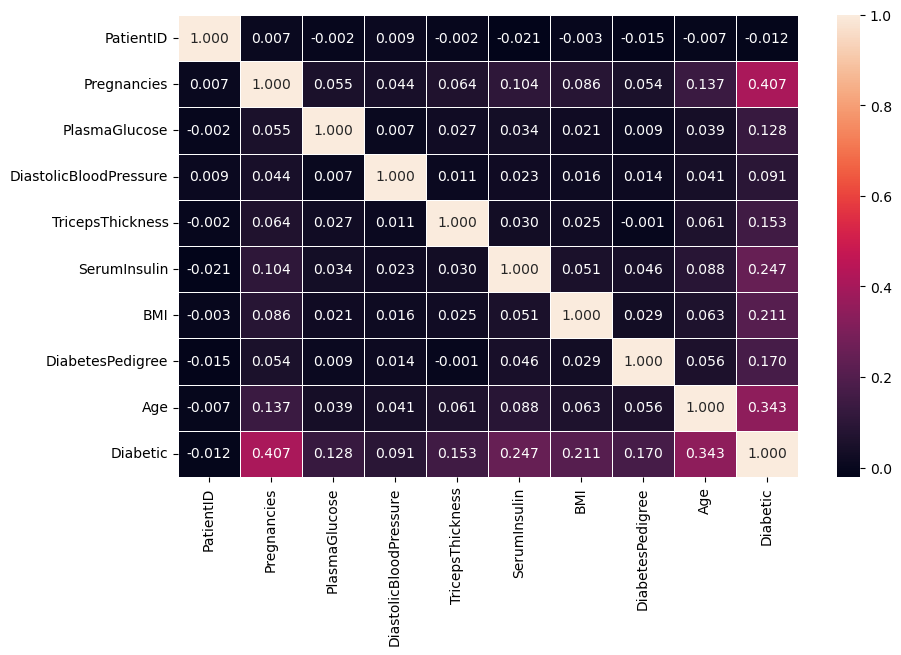

In [31]:
# Heatmap correlation matrix
f, ax = plt.subplots(figsize = (10, 6))
sns.heatmap(original_df.corr(), annot = True, fmt = ".3f", linewidths = 0.5, ax = ax)

### **Strongest to weakest relationships with the target**

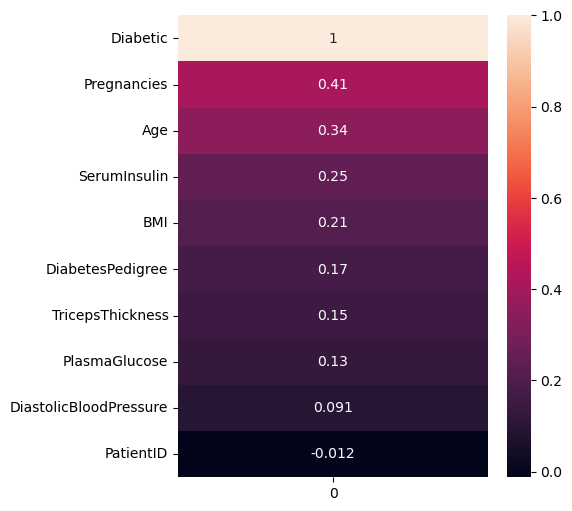

In [32]:
# Correlations visualization of features vs. target
outcome_corr = original_df.corrwith(original_df["Diabetic"])
corr_df = outcome_corr.sort_values(ascending = False).to_frame()
fig, ax = plt.subplots(figsize = (5, 6))
sns.heatmap(corr_df, annot = True, ax = ax)
plt.show()

### **Relationships between features with slighly significant correlations**

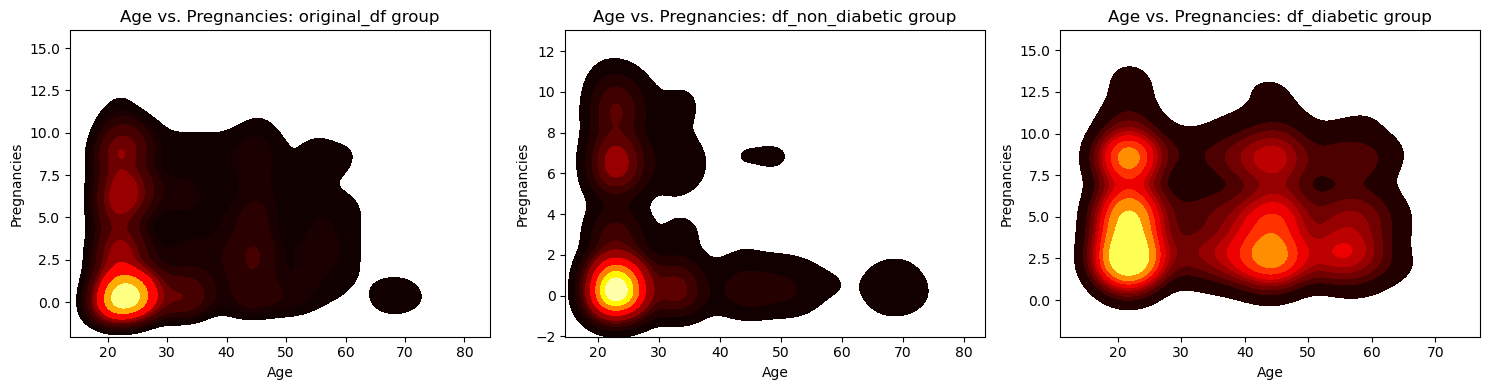

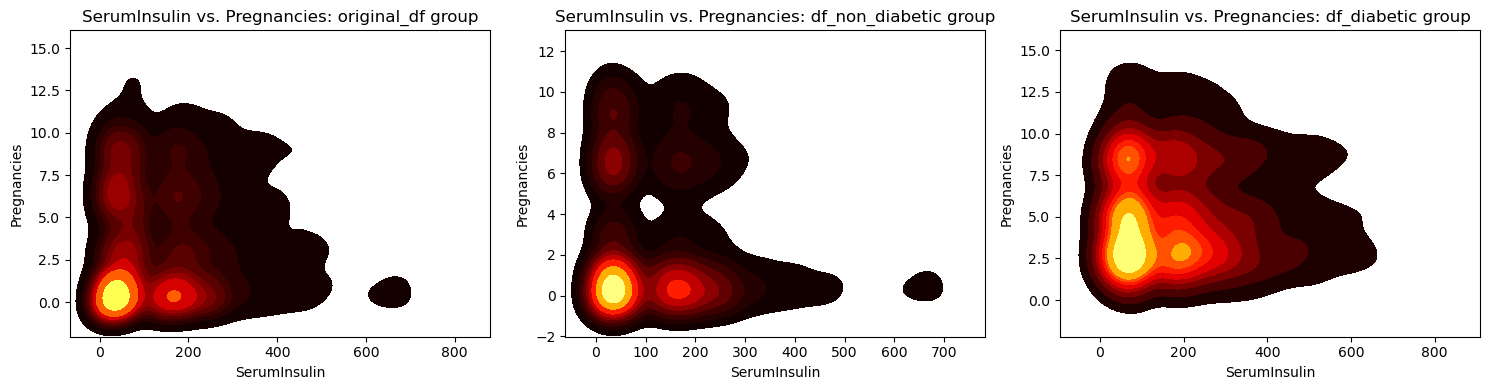

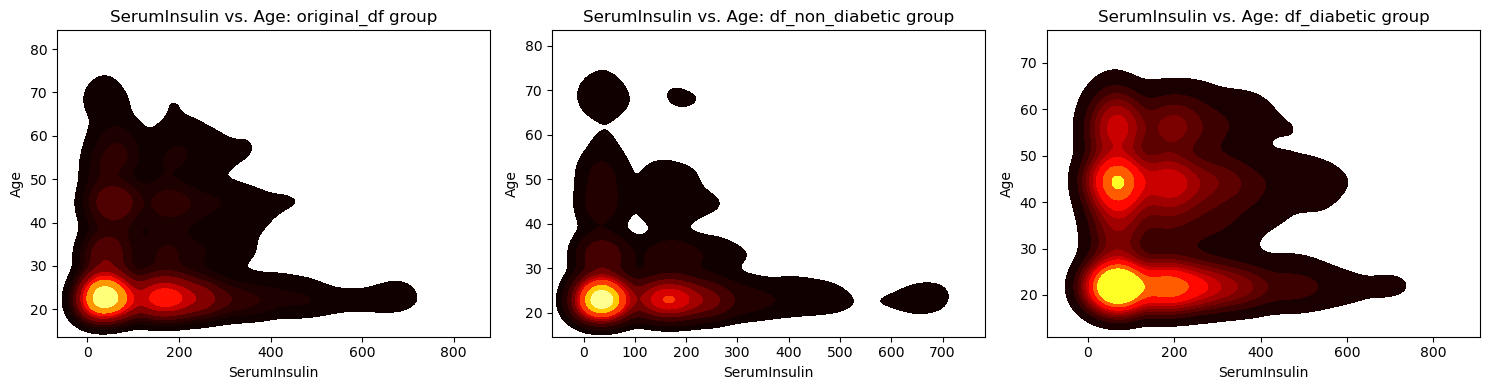

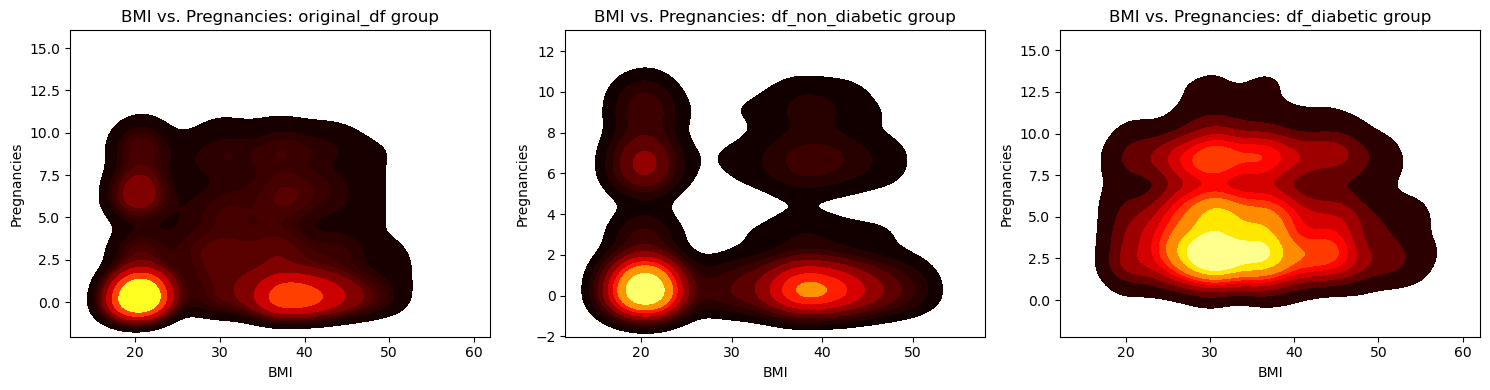

In [32]:
# Study-pair visualizations of the most correlated feature pairings according to the correlation matrix
study_pair = [("Age", "Pregnancies"), ("SerumInsulin", "Pregnancies"), ("SerumInsulin", "Age"), ("BMI", "Pregnancies")]
for x,y in study_pair:
    heatmap_per_col([original_df, df_non_diabetic, df_diabetic], ["original_df", "df_non_diabetic", "df_diabetic"], x, y)

**Additional notes:**
* The positive correlation hints to us that the above present features have a positive relationship to our target (Diabetic), meaning that as they increase, the possibility of having a diabetes increases as well.
* Pregnancies (~0.41), age (~0.34) and serum insulin (~0.25) are top 3 features that have the strongest correlation with the diabetes status therefore they might be stronger predictors of the diabetic outcome than the rest of the features.
* Triceps thickness, plasma glucose and diastolic blood pressure having rather weak positive correlation might still contribute to the prediction of the diabetic outcome, but are not individually strong predictors in the given dataset.
* Until now, we have not established any pattern inside the PatientID column, despite many visualizations and statistical data obervations. The column can be dropped, as it cannot be used as a predictor, and no features will be engineered based on it.

---
## **3.3 Outliers detection & understanding**

**This part is dedicated to:**
* detect the presence of potential outliers;
* understand the nature of the outliers present in the dataset;
* decide on how to treat the outliers present in the dataset.

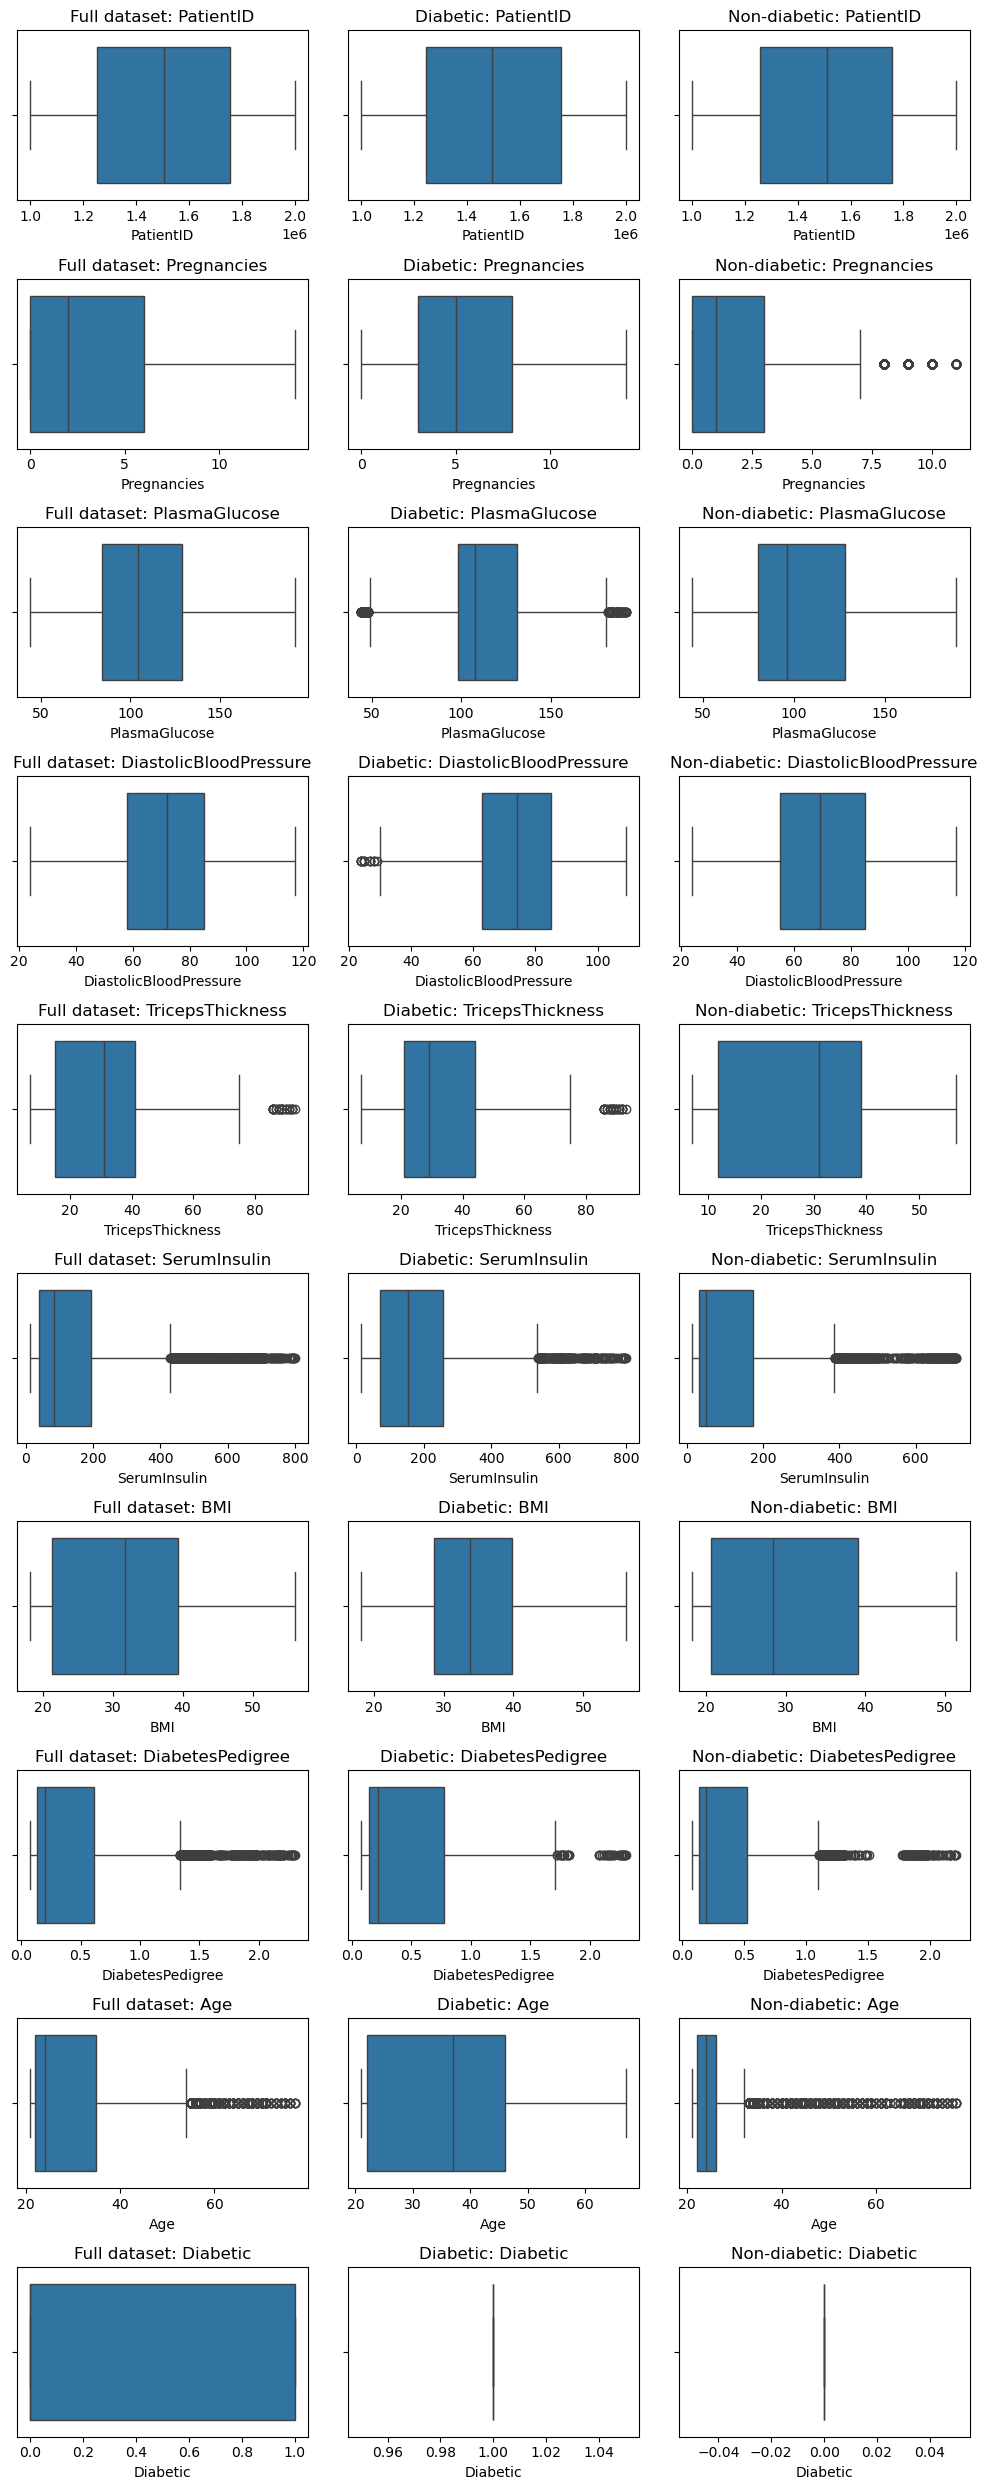

In [33]:
# Detection of outliers using the boxplot visualization ; split by diabetic outcome for clearer view
columns = original_df.columns
nb_rows = len(columns)

fig, axes = plt.subplots(ncols = 3, nrows = nb_rows, figsize = (10, 25))

for i, col in enumerate(columns):
        sns.boxplot(data = original_df, x = col, ax = axes[i, 0])
        axes[i, 0].set_title(f"Full dataset: {col}")
        
        sns.boxplot(data = df_diabetic, x = col, ax=axes[i, 1])
        axes[i, 1].set_title(f"Diabetic: {col}")
        
        sns.boxplot(data = df_non_diabetic, x = col, ax = axes[i, 2])
        axes[i, 2].set_title(f"Non-diabetic: {col}")

plt.tight_layout()
plt.show()

### Understanding DiabetesPedigree outliers patients

In [34]:
# Creation of DiabetesPedigree outliers dataframe
diabetespedigree_outliers_df = isolate_outliers(original_df, "DiabetesPedigree")
diabetespedigree_outliers_df.describe()

PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
count  4.750000e+02   475.000000     475.000000              475.000000   
mean   1.482876e+06     4.397895     110.370526               72.568421   
std    2.962054e+05     3.358910      30.139296               15.408128   
min    1.000326e+06     0.000000      44.000000               33.000000   
25%    1.211071e+06     2.000000      94.000000               62.000000   
50%    1.490189e+06     4.000000     107.000000               74.000000   
75%    1.736458e+06     7.000000     125.500000               84.000000   
max    1.999319e+06    14.000000     190.000000              109.000000   

       TricepsThickness  SerumInsulin         BMI  DiabetesPedigree  \
count        475.000000    475.000000  475.000000        475.000000   
mean          30.284211    173.122105   33.644983          1.644478   
std           15.201920    154.662167    9.029485          0.259062   
min            7.000000     14.000000   18.230396          1.335312   
25%           15.000000     60.000000   27.011556          1.451112   
50%           30.000000    134.000000   34.683928          1.544995   
75%           42.000000    238.500000   39.302858          1.837285   
max           89.000000    795.000000   55.579601          2.301594   

              Age    Diabetic  
count  475.000000  475.000000  
mean    33.042105    0.738947  
std     12.996848    0.439672  
min     21.000000    0.000000  
25%     22.000000    0.000000  
50%     25.000000    1.000000  
75%     44.000000    1.000000  
max     70.000000    1.000000

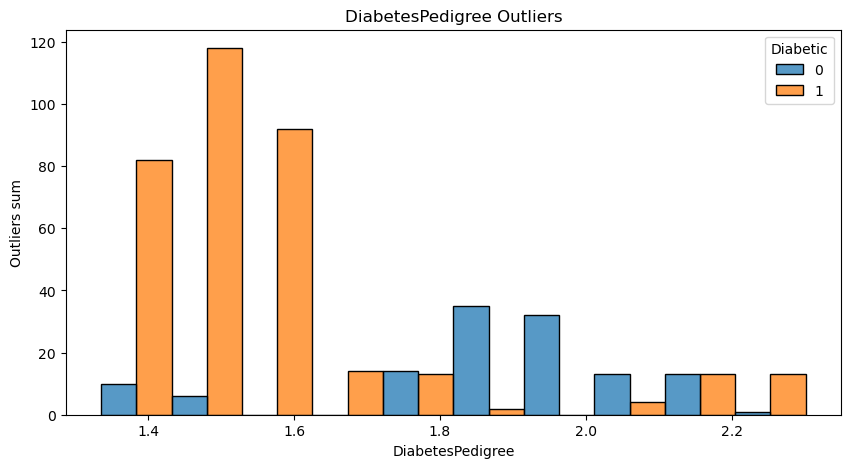

In [35]:
plot_outliers(original_df, "DiabetesPedigree")

### Understanding Age outliers patients

In [36]:
# Creation of Age outliers dataframe
age_outliers_df = isolate_outliers(original_df, "Age")
age_outliers_df.describe()

PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
count  1.019000e+03  1019.000000    1019.000000             1019.000000   
mean   1.500490e+06     4.249264     110.735034               72.858685   
std    2.864147e+05     3.356179      32.655348               15.837884   
min    1.001511e+06     0.000000      44.000000               24.000000   
25%    1.248140e+06     1.000000      91.000000               61.000000   
50%    1.504006e+06     4.000000     107.000000               75.000000   
75%    1.752738e+06     7.000000     131.000000               86.000000   
max    1.999836e+06    14.000000     191.000000              115.000000   

       TricepsThickness  SerumInsulin          BMI  DiabetesPedigree  \
count       1019.000000   1019.000000  1019.000000       1019.000000   
mean          30.938175    164.834151    32.934669          0.432591   
std           14.655209    148.749843     9.042747          0.398585   
min            7.000000     14.000000    18.203229          0.078107   
25%           19.000000     52.000000    25.516965          0.137534   
50%           31.000000     95.000000    33.038855          0.205770   
75%           43.000000    233.000000    39.542256          0.687730   
max           88.000000    786.000000    55.975311          2.284497   

               Age     Diabetic  
count  1019.000000  1019.000000  
mean     61.046124     0.672228  
std       5.414710     0.469632  
min      55.000000     0.000000  
25%      57.000000     0.000000  
50%      60.000000     1.000000  
75%      66.000000     1.000000  
max      77.000000     1.000000

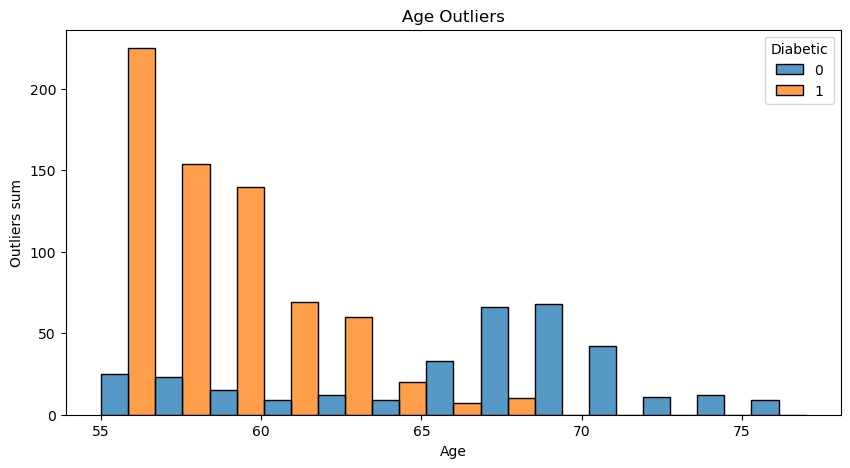

In [ ]:
# Age impact on diabetic outcome
plot_outliers(original_df, "Age")

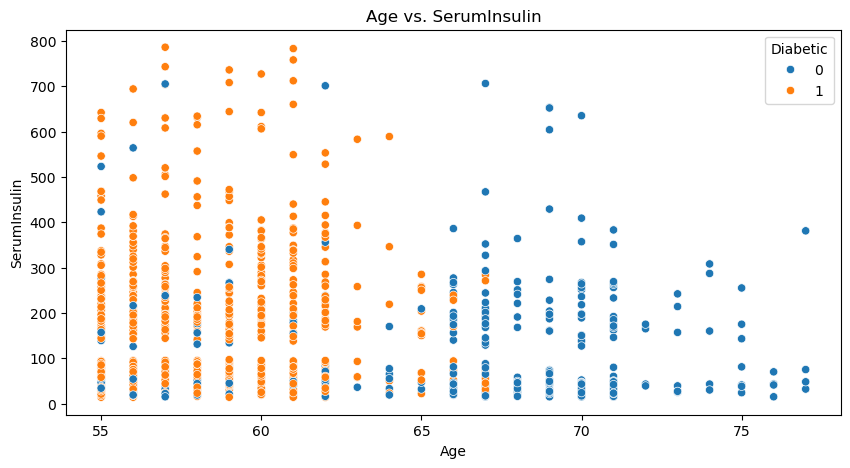

In [ ]:
# Age vs Serum Insulin impact on diabetic outcome
plt.figure(figsize = (10, 5))
sns.scatterplot(data = age_outliers_df, x = "Age", y = "SerumInsulin", hue = "Diabetic")
plt.title("Age vs. SerumInsulin")
plt.xlabel("Age")
plt.ylabel("SerumInsulin")
plt.show()

### Understanding SerumInsulin outliers patients

In [39]:
# Creation of SerumInsulin outliers dataframe
seruminsulin_outliers_df = isolate_outliers(original_df, "SerumInsulin")
seruminsulin_outliers_df.describe()

PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
count  6.660000e+02   666.000000     666.000000              666.000000   
mean   1.470413e+06     4.091592     109.582583               71.957958   
std    3.009583e+05     3.476108      31.050286               16.300414   
min    1.000038e+06     0.000000      45.000000               24.000000   
25%    1.200253e+06     1.000000      89.000000               61.000000   
50%    1.440420e+06     3.000000     106.500000               73.000000   
75%    1.755328e+06     7.000000     129.500000               84.000000   
max    1.999656e+06    14.000000     187.000000              116.000000   

       TricepsThickness  SerumInsulin         BMI  DiabetesPedigree  \
count        666.000000    666.000000  666.000000        666.000000   
mean          29.935435    560.043544   32.762460          0.432610   
std           14.876849     95.032687    9.249274          0.426764   
min            7.000000    430.000000   18.220534          0.078093   
25%           15.250000    475.000000   24.640532          0.134413   
50%           30.500000    540.000000   32.925818          0.191495   
75%           42.000000    639.000000   39.632968          0.692037   
max           92.000000    799.000000   55.682362          2.296062   

              Age    Diabetic  
count  666.000000  666.000000  
mean    32.100601    0.600601  
std     12.854668    0.490143  
min     21.000000    0.000000  
25%     22.000000    0.000000  
50%     25.000000    1.000000  
75%     43.000000    1.000000  
max     70.000000    1.000000

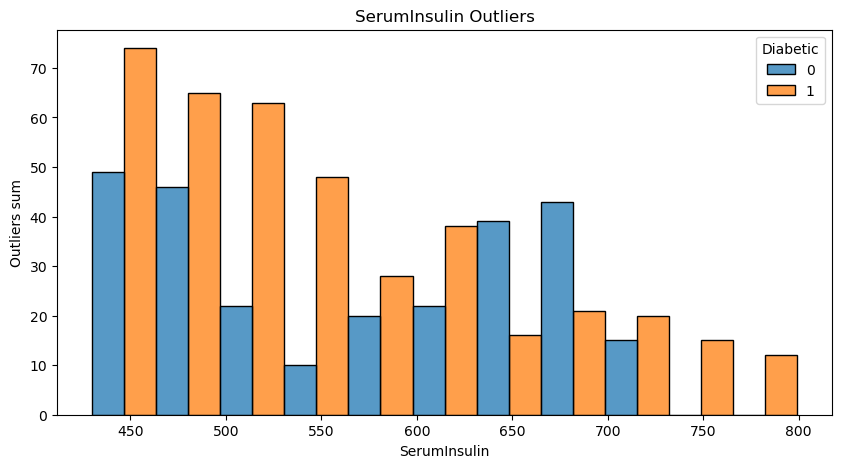

In [ ]:
# Serum Insulin impact on diabetic outcome
plot_outliers(original_df, "SerumInsulin")

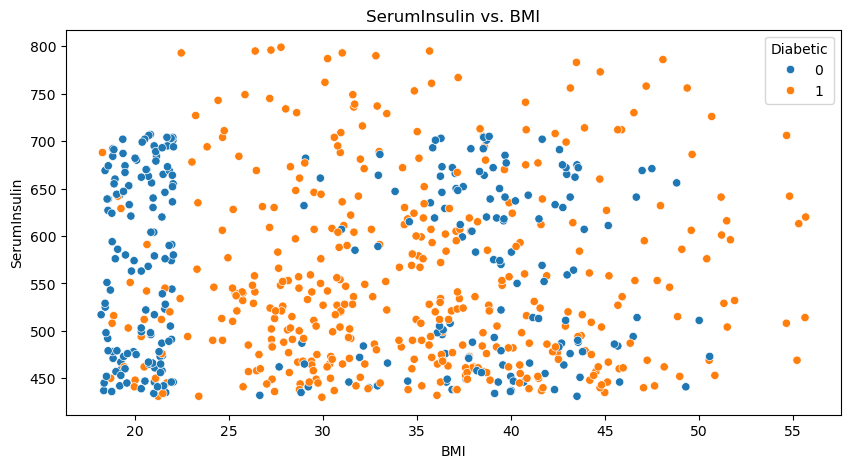

In [ ]:
# Serum Insulin vs BMI impact on diabetic outcome
plt.figure(figsize = (10, 5))
sns.scatterplot(data = seruminsulin_outliers_df, x = "BMI", y = "SerumInsulin", hue = "Diabetic")
plt.title("SerumInsulin vs. BMI")
plt.xlabel("BMI")
plt.ylabel("SerumInsulin")
plt.show()

### Understanding TricepsThickness outliers patients

In [43]:
# Creation of TricepsThickness outliers dataframe
tricepsthickness_outliers_df = isolate_outliers(original_df, "TricepsThickness")
tricepsthickness_outliers_df.describe()

PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
count  3.100000e+01    31.000000      31.000000               31.000000   
mean   1.537026e+06     5.709677     109.419355               69.774194   
std    3.012828e+05     3.465964      29.278859               16.272082   
min    1.016703e+06     2.000000      50.000000               24.000000   
25%    1.271522e+06     3.000000      93.000000               60.500000   
50%    1.633395e+06     4.000000     108.000000               68.000000   
75%    1.787080e+06     8.000000     129.000000               82.500000   
max    1.959435e+06    14.000000     172.000000              104.000000   

       TricepsThickness  SerumInsulin        BMI  DiabetesPedigree        Age  \
count         31.000000     31.000000  31.000000         31.000000  31.000000   
mean          88.774194    207.935484  32.670001          0.541676  34.000000   
std            2.231736    181.025032   6.816047          0.471734  14.127986   
min           86.000000     19.000000  18.565014          0.080802  21.000000   
25%           86.500000     77.000000  27.339736          0.114809  22.000000   
50%           89.000000    159.000000  31.497189          0.252592  23.000000   
75%           90.500000    285.500000  37.125366          0.976691  46.000000   
max           93.000000    793.000000  49.635205          1.540531  61.000000   

       Diabetic  
count      31.0  
mean        1.0  
std         0.0  
min         1.0  
25%         1.0  
50%         1.0  
75%         1.0  
max         1.0

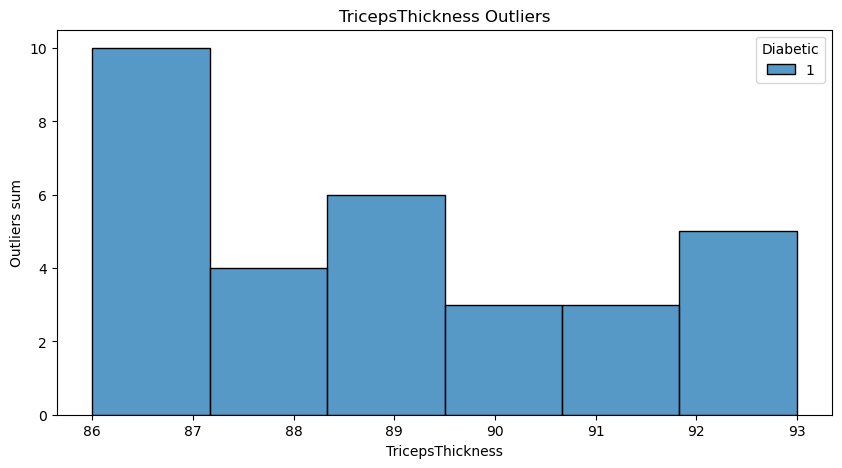

In [ ]:
# Triceps thickness impact on diabetic outcome
plot_outliers(original_df, "TricepsThickness")

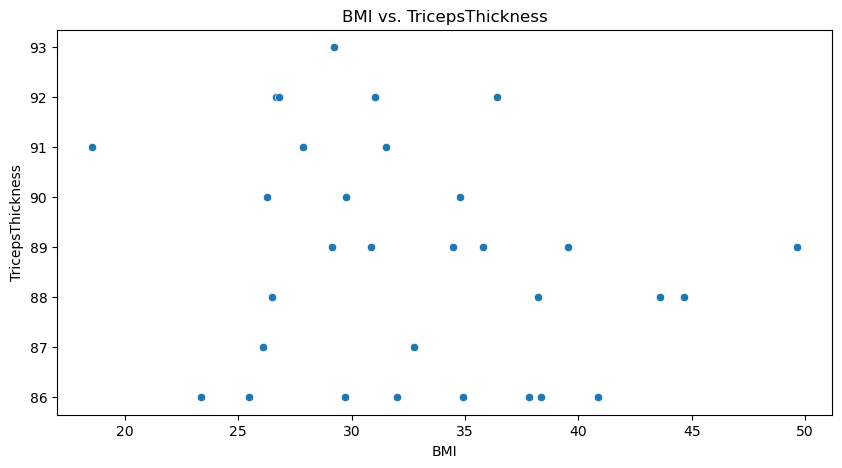

In [ ]:
# BMI vs. Triceps thickness impact on diabetic outcome
plt.figure(figsize = (10, 5))
sns.scatterplot(data = tricepsthickness_outliers_df, x = "BMI", y = "TricepsThickness")
plt.title("BMI vs. TricepsThickness")
plt.xlabel("BMI")
plt.ylabel("TricepsThickness")
plt.show()

#### **Outliers detection observations**:
* Presence of many outliers in 4 features (descending order): Age, SerumInsulin, DiabetesPedigree, TricepsThickness.
* Outliers present in the dataset might be meaningful and provide insights into less-frequent cases, and not necessarily be erronous data.
* Some of the ML models (ex. KNN, logistic regression) can be heavily impacted by the presence of these outliers if left untreated.

#### **Outliers detection implications**:
* **Large number of outliers excludes the direct removal approach**, since it would imply a significant size change of the dataset. Presence of these extreme values might be a result of real cases, where these outliers are meaningful and are simply detected as such as a result of their IQR distance.
* **Age outliers:** For the age outliers, patients can legitimately be very young or very old. Extreme age values present in the dataset are highly unlikely to be erronous data entry, and are simply a result of under-represented class in the dataset. As such, they should be left in the dataset.
* **DiabetesPedigree outliers:** can be explained by the nature this indicator (a probability of diabetes based on family history). Because an individual has a predisposition, doesn't necessary mean that they are diagnosed as diabetic.
* **TricepsThickness outliers:** Patients with values in the 86-93 range have all been diagnosed with diabetes. Since obesity (a common cause of high triceps thickness) is a known risk factor, these values likely reflect real-world cases and should be retained. Using a stanard BMI categories for women, values above 24 indicate being overweight, and 27 can be categorised as obesity. There is a single instance of a patient with low BMI score and high TricepsThickness value, however in view of the dataset size, as well as the models choice, this isolated case is not concerning.
* **SerumInsulin outliers:** The distribution of both diabetic and non-diabetic groups seem rather similar, with only diabetic patients on the higher end of the distribution. Serum Insulin outliers patients howeer seem to be on the higher end of the obesity scale, with crushing majority of them having over 25 BMI.

* **Impact on the preselected models**: Because of the decision to keep the outliers (which will introduce the noise to the learning patterns), as well as considering the data distribution shapes, we will not use initially preselected models that are incompatible with the data characteristics present in this dataset. Therefore, We are going to select 3 tree-based models, which are XGBoost, Random Forest and Decision Tree for their robustness when it comes to outliers and unsymetrical data distributions.

---
# **4. DATA PREPROCESSING & FEATURE ENGINEERING**
---

## **4.0 PIMA indian dataset preparation for secondary validation**

As a secondary verification measure of the model validation decision process, we will be using PIMA indian dataset, that contains exactly the same features as our base dataset used for training the models. Before passing the raw data, we will have a look on it to quickly verify any anomalies (ex. missing values) and sanitize it if necessary using techniques that do not synthetise the data points. The assumption with this dataset is that it contains real-world data, independent from the training set.

In [46]:
# Original df import and creation of a deep copy
pima_indian_dataset = pd.read_csv(r"../Notebooks/pima_indian_dataset.csv")
pima_indian_dataset_raw = pima_indian_dataset.copy()

pima_indian_dataset.info()
pima_indian_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

The features names in the PIMA dataset were previously verified and are exactly the same indicators as the ones used in our training set, even though their names vary. THerefore, we will allign their names.

In [47]:
# Features name change 
pima_indian_dataset = pima_indian_dataset.rename(columns=
    {"Glucose": "PlasmaGlucose",
    "BloodPressure": "DiastolicBloodPressure",
    "SkinThickness": "TricepsThickness",
    "Insulin": "SerumInsulin",
    "DiabetesPedigreeFunction": "DiabetesPedigree",
    "Outcome":"Diabetic"})

pima_indian_dataset.describe()

Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  \
count   768.000000     768.000000              768.000000        768.000000   
mean      3.845052     120.894531               69.105469         20.536458   
std       3.369578      31.972618               19.355807         15.952218   
min       0.000000       0.000000                0.000000          0.000000   
25%       1.000000      99.000000               62.000000          0.000000   
50%       3.000000     117.000000               72.000000         23.000000   
75%       6.000000     140.250000               80.000000         32.000000   
max      17.000000     199.000000              122.000000         99.000000   

       SerumInsulin         BMI  DiabetesPedigree         Age    Diabetic  
count    768.000000  768.000000        768.000000  768.000000  768.000000  
mean      79.799479   31.992578          0.471876   33.240885    0.348958  
std      115.244002    7.884160          0.331329   11.760232    0.476951  
min        0.000000    0.000000          0.078000   21.000000    0.000000  
25%        0.000000   27.300000          0.243750   24.000000    0.000000  
50%       30.500000   32.000000          0.372500   29.000000    0.000000  
75%      127.250000   36.600000          0.626250   41.000000    1.000000  
max      846.000000   67.100000          2.420000   81.000000    1.000000

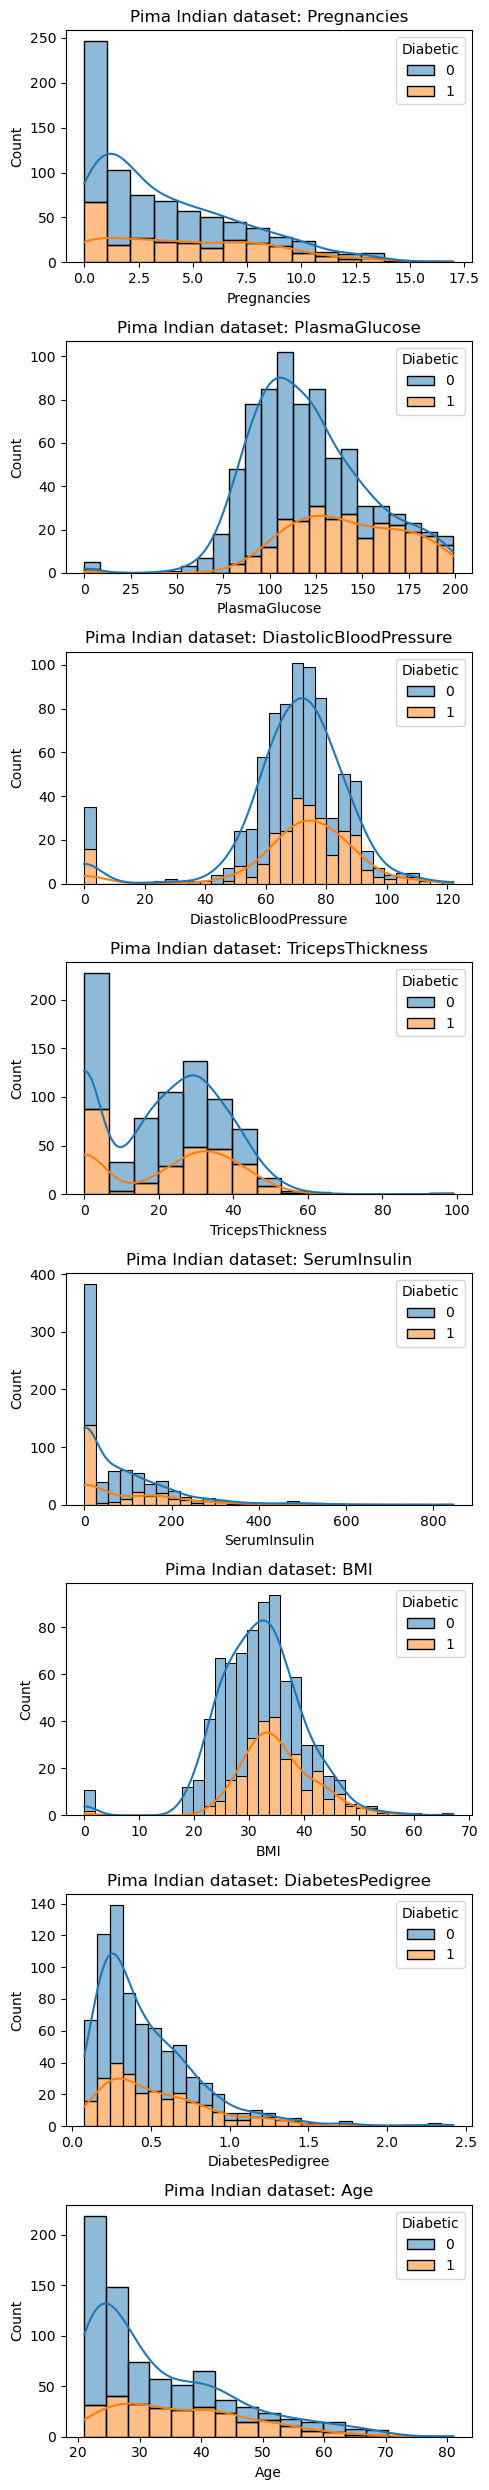

In [48]:
# Verification of the data distributions for the PIMA Indian dataset
fig, axes = plt.subplots(nrows = len(pima_indian_dataset.columns)-1, ncols = 1, figsize = (5, 25))

for i, col in enumerate(pima_indian_dataset.columns):
    if col not in ["Diabetic"]:
        sns.histplot(data = pima_indian_dataset, x = col, hue = "Diabetic", multiple = "stack", kde = True, ax = axes[i])
        axes[i].set_title(f"Pima Indian dataset: {col}")
        
plt.tight_layout()
plt.show()

Many zero values present in the dataset. Since it is a real world data, concerning a sensitive subject of health, as well as secondary validation dataset in additional to the regular training set, we will tweak it only using minimal measures, by dropping the rows with 0 values in the columns, with the exception of pregnancies number and diabetic outcome, to focus only on patients that underwent a full medical check-up.

In [49]:
# Dropping the rows with 0 values present across the features
cols = pima_indian_dataset.columns.drop(["Diabetic", "Pregnancies"])
pima_trimmed = pima_indian_dataset[(pima_indian_dataset[cols] != 0).all(axis = 1)]
pima_trimmed.describe()

Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  \
count   392.000000     392.000000              392.000000        392.000000   
mean      3.301020     122.627551               70.663265         29.145408   
std       3.211424      30.860781               12.496092         10.516424   
min       0.000000      56.000000               24.000000          7.000000   
25%       1.000000      99.000000               62.000000         21.000000   
50%       2.000000     119.000000               70.000000         29.000000   
75%       5.000000     143.000000               78.000000         37.000000   
max      17.000000     198.000000              110.000000         63.000000   

       SerumInsulin         BMI  DiabetesPedigree         Age    Diabetic  
count    392.000000  392.000000        392.000000  392.000000  392.000000  
mean     156.056122   33.086224          0.523046   30.864796    0.331633  
std      118.841690    7.027659          0.345488   10.200777    0.471401  
min       14.000000   18.200000          0.085000   21.000000    0.000000  
25%       76.750000   28.400000          0.269750   23.000000    0.000000  
50%      125.500000   33.200000          0.449500   27.000000    0.000000  
75%      190.000000   37.100000          0.687000   36.000000    1.000000  
max      846.000000   67.100000          2.420000   81.000000    1.000000

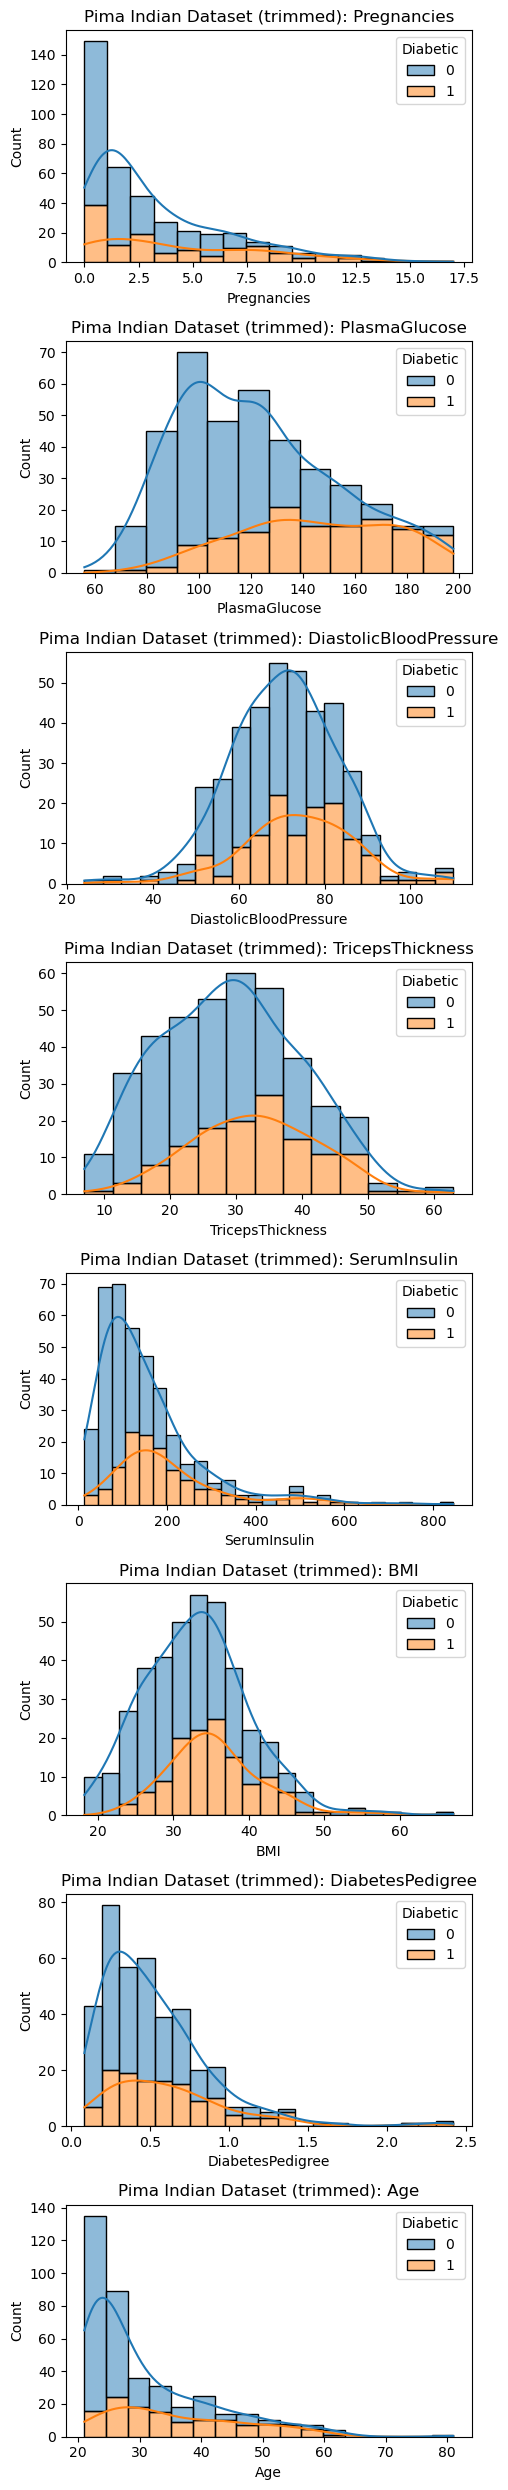

In [50]:
# Verification of the data distributions for the trimmed PIMA Indian dataset
fig, axes = plt.subplots(nrows = len(pima_trimmed.columns)-1, ncols = 1, figsize = (5, 25))

for i, col in enumerate(pima_trimmed.columns):
    if col not in ["Diabetic"]:
        sns.histplot(data = pima_trimmed, x = col, hue = "Diabetic", multiple="stack", kde = True, ax = axes[i])
        axes[i].set_title(f"Pima Indian Dataset (trimmed): {col}")
        
plt.tight_layout()
plt.show()

#### **PIMA Indian dataset preparation comments**:
* Dropping zero values reduced the dataset size by nearly half, but this is not a concern. This dataset is only used for second validation purposes as an extra indicator, not intended as a source of absolute truth.
* Removing zeros makes the data more adapted to the training of the models, and prevents them from erronous interpretation of the missing values. This trade-off will lead to more reliable results.
* Data distributions of this set are similar to the training model, making it a great fit for application of similar transformations during the model improvement iterations.

### **4.1 Feature Engineering 1: BMI categories**

* Knowing that BMI is an indicator that allows us to categorize individuals on obesity scale, and obesity might be a strong predictor of the diabetes outcome, we will bin this feature into 5 categories to help train the models.
* BMI bins will be engineered based on domain knowledge, adapted to the Taiwanese adult population, based on a study https://pmc.ncbi.nlm.nih.gov/articles/PMC8306797/.
* BMI bins will be further encoded using ordinal encoder, which retains ordinal relationship accross the categories.

In [51]:
# Deep copy of the datasets before applying the transformation
df_before_engineering = original_df.drop("PatientID", axis = 1)
df_pima_before_engineering = pima_trimmed.copy()

In [52]:
# Preparation of the dataframe for feature engineering, without PatientID
df_engineered = original_df.drop("PatientID", axis = 1)

# Preparation of the secondary validation PIMA dataset for feature engineering
df_engineered_pima = pima_trimmed.copy()


# Creation of a BMI binning function
def bmi_categorization(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif bmi < 24:
        return "Normal weight"
    elif bmi < 27:
        return "Overweight"
    elif bmi < 35:
        return "Obese"
    else:
        return "Severely obese"

# Preparation of BMI ordinal encoder
bmi_ordinal_encoder = {
    "Underweight": 0,
    "Normal weight": 1,
    "Overweight": 2,
    "Obese": 3,
    "Severely obese": 4}

# Transformations of the datasets
df_engineered["bmi_categorical"] = df_engineered["BMI"].apply(bmi_categorization)
df_engineered["bmi_category"] = df_engineered["bmi_categorical"].map(bmi_ordinal_encoder)
df_engineered = df_engineered.drop("bmi_categorical", axis = 1)

df_engineered_pima["bmi_categorical"] = df_engineered_pima["BMI"].apply(bmi_categorization)
df_engineered_pima["bmi_category"] = df_engineered_pima["bmi_categorical"].map(bmi_ordinal_encoder)
df_engineered_pima = df_engineered_pima.drop("bmi_categorical", axis = 1)

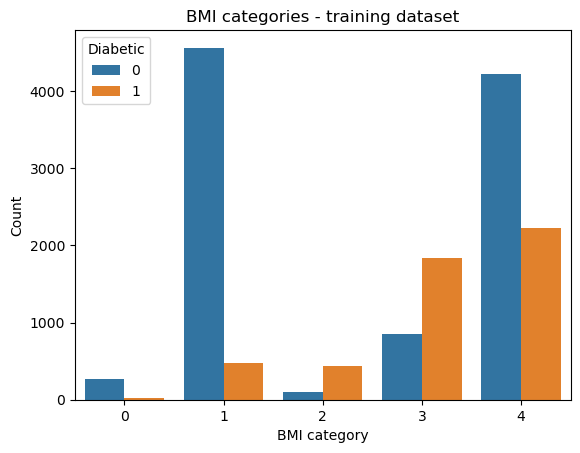

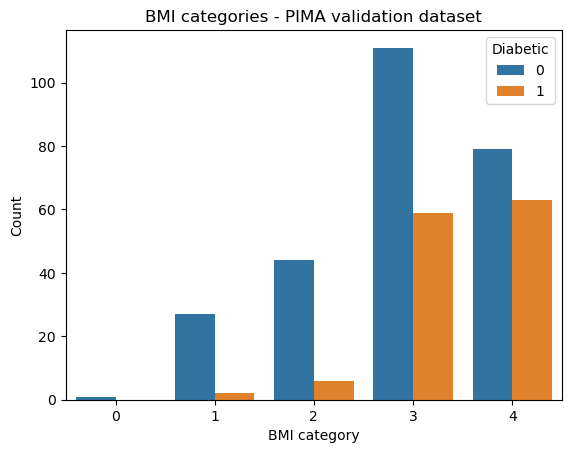

In [53]:
# Visualization of the new BMI category feature for out dataset

# Training dataset
sns.countplot(data = df_engineered, x = "bmi_category", hue = "Diabetic")
plt.xlabel("BMI category")
plt.ylabel("Count")
plt.title("BMI categories - training dataset")
plt.show()

# Pima dataset
sns.countplot(data = df_engineered_pima, x = "bmi_category", hue = "Diabetic")
plt.xlabel("BMI category")
plt.ylabel("Count")
plt.title("BMI categories - PIMA validation dataset")
plt.show()

### **Feature Engineering 2: Over-sampling the minority classes using SMOTE**

* In order to address the classes imbalances of the dataset, we are going to over-sample the minority classes using he SMOTE technique.
* The base case (before any resampling applied) is going to serve us as a starting point to see the differences in our models performance.
* The base case split is stratified, to ensure the correct distribution of classes of the target variable.

In [54]:
# Split of the engineered dataset into train and test dataset ; choice of the stratifiedkfold : because of imbalanced classes and each record is unique - no patient went through multiple checkups
X = df_engineered.drop(columns = ["Diabetic"])
y = df_engineered["Diabetic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

# Split of the pima indian dataset into additional validation test dataset
X_pima = df_engineered_pima.drop(columns = ["Diabetic"])
y_pima = df_engineered_pima["Diabetic"]

In [55]:
# Base dataset statistical description
X_train.describe()

Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  \
count  12000.000000   12000.000000            12000.000000      12000.000000   
mean       3.225417     107.851000               71.251583         28.684500   
std        3.387855      31.970032               16.740046         14.528066   
min        0.000000      44.000000               24.000000          7.000000   
25%        0.000000      84.000000               58.000000         15.000000   
50%        2.000000     104.000000               72.000000         30.000000   
75%        6.000000     129.000000               85.000000         41.000000   
max       14.000000     192.000000              117.000000         93.000000   

       SerumInsulin           BMI  DiabetesPedigree           Age  \
count  12000.000000  12000.000000      12000.000000  12000.000000   
mean     137.586583     31.432391          0.398796     30.135000   
std      132.548425      9.765665          0.377158     12.062223   
min       14.000000     18.200512          0.078044     21.000000   
25%       39.000000     21.229006          0.137769     22.000000   
50%       83.000000     31.653219          0.200250     24.000000   
75%      194.000000     39.181738          0.617375     35.000000   
max      799.000000     56.034628          2.296062     77.000000   

       bmi_category  
count  12000.000000  
mean       2.655417  
std        1.368089  
min        0.000000  
25%        1.000000  
50%        3.000000  
75%        4.000000  
max        4.000000

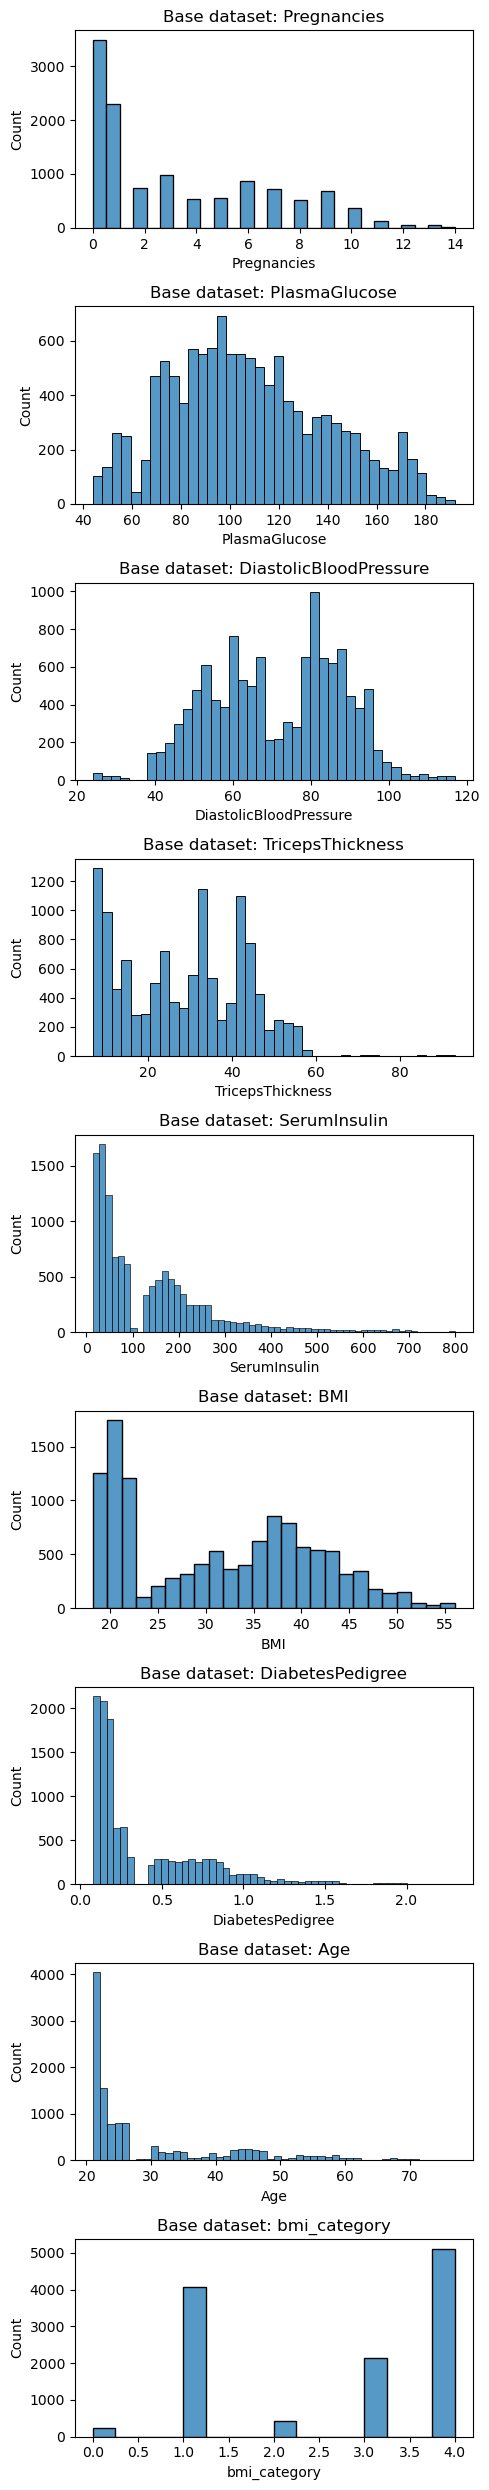

In [56]:
# Base dataset data distribution
fig, axes = plt.subplots(nrows = len(X_train.columns), ncols = 1, figsize = (5, 25))

for i, col in enumerate(X_train.columns):
    sns.histplot(data = X_train, x = col, multiple="stack", ax = axes[i])
    axes[i].set_title(f"Base dataset: {col}")
        
plt.tight_layout()
plt.show()

In [82]:
# Application of SMOTE over-sampling method on the base datasets
smote = SMOTE(random_state = 0)

X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)
X_smote_train.describe()

Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  \
count  16000.000000   16000.000000            16000.000000      16000.000000   
mean       3.553625     109.388688               71.869687         29.457500   
std        3.223123      31.641301               15.913557         14.596481   
min        0.000000      44.000000               24.000000          7.000000   
25%        1.000000      87.000000               60.000000         15.000000   
50%        3.000000     106.000000               73.000000         30.000000   
75%        6.000000     129.000000               85.000000         42.000000   
max       14.000000     192.000000              117.000000         92.000000   

       SerumInsulin           BMI  DiabetesPedigree           Age  \
count  16000.000000  16000.000000      16000.000000  16000.000000   
mean     150.641687     32.164996          0.425294     31.465062   
std      140.193546      9.264968          0.379184     12.572441   
min       14.000000     18.200512          0.078044     21.000000   
25%       44.000000     21.892395          0.146608     22.000000   
50%       91.000000     32.399813          0.237918     25.000000   
75%      209.000000     39.107956          0.653953     42.000000   
max      799.000000     56.034628          2.301594     77.000000   

       bmi_category  
count  16000.000000  
mean       2.730000  
std        1.275275  
min        0.000000  
25%        1.000000  
50%        3.000000  
75%        4.000000  
max        4.000000

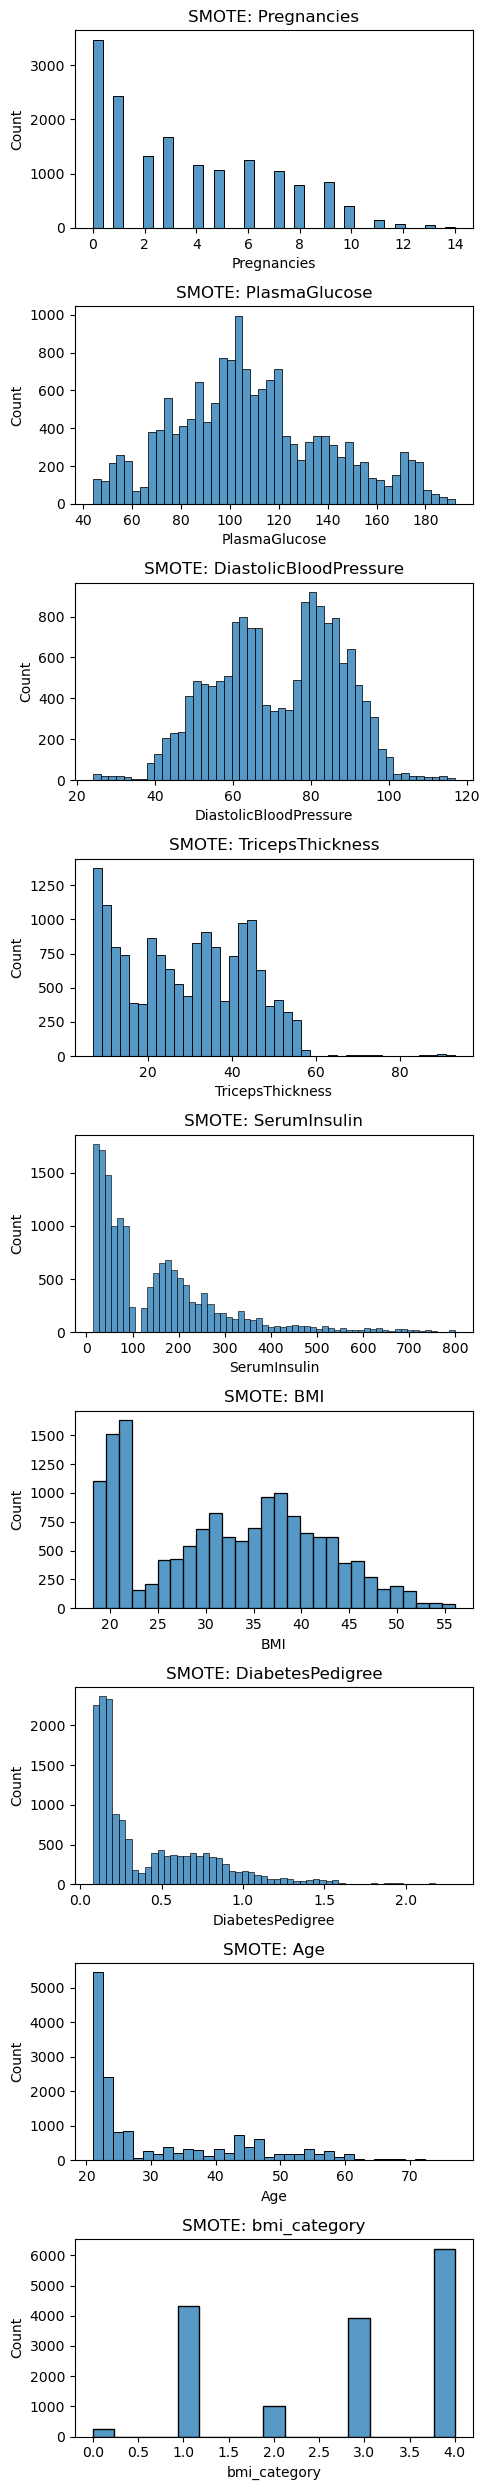

In [76]:
# Verification of the data distributions for the over-sampled dataset
fig, axes = plt.subplots(nrows = len(X_smote_train.columns), ncols = 1, figsize = (5, 25))

for i, col in enumerate(X_smote_train.columns):
    sns.histplot(data = X_smote_train, x = col, multiple = "stack", ax = axes[i])
    axes[i].set_title(f"SMOTE: {col}")

plt.tight_layout()
plt.show()

### **Feature Engineering 3: Under-sampling the majority classes with Edited Nearest Neighbors**

* Under-sampling of the base dataset, in order to tackle the class imbalance issue. THis time, the approach chosen is to remove the samples, instead of synthetically adding them.

In [86]:
# Application of ENN under-sampling method on the base datasets
enn = EditedNearestNeighbours()
X_enn_train, y_enn_train = enn.fit_resample(X_train, y_train)
X_enn_train.describe()

Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  \
count   9624.00000    9624.000000             9624.000000       9624.000000   
mean       3.32554     107.380715               71.016209         28.782003   
std        3.36342      32.112344               16.637636         14.729621   
min        0.00000      44.000000               24.000000          7.000000   
25%        0.00000      83.000000               58.000000         15.000000   
50%        2.00000     104.000000               72.000000         30.000000   
75%        6.00000     128.000000               85.000000         41.000000   
max       14.00000     192.000000              117.000000         92.000000   

       SerumInsulin          BMI  DiabetesPedigree          Age  bmi_category  
count   9624.000000  9624.000000       9624.000000  9624.000000   9624.000000  
mean     129.680486    31.310395          0.413491    29.818059      2.640274  
std      128.593297     9.740452          0.389588    11.595867      1.354791  
min       14.000000    18.200512          0.078044    21.000000      0.000000  
25%       37.000000    21.253099          0.139300    22.000000      1.000000  
50%       77.000000    31.201147          0.202491    24.000000      3.000000  
75%      186.000000    38.950113          0.647928    35.000000      4.000000  
max      799.000000    56.034628          2.301594    77.000000      4.000000

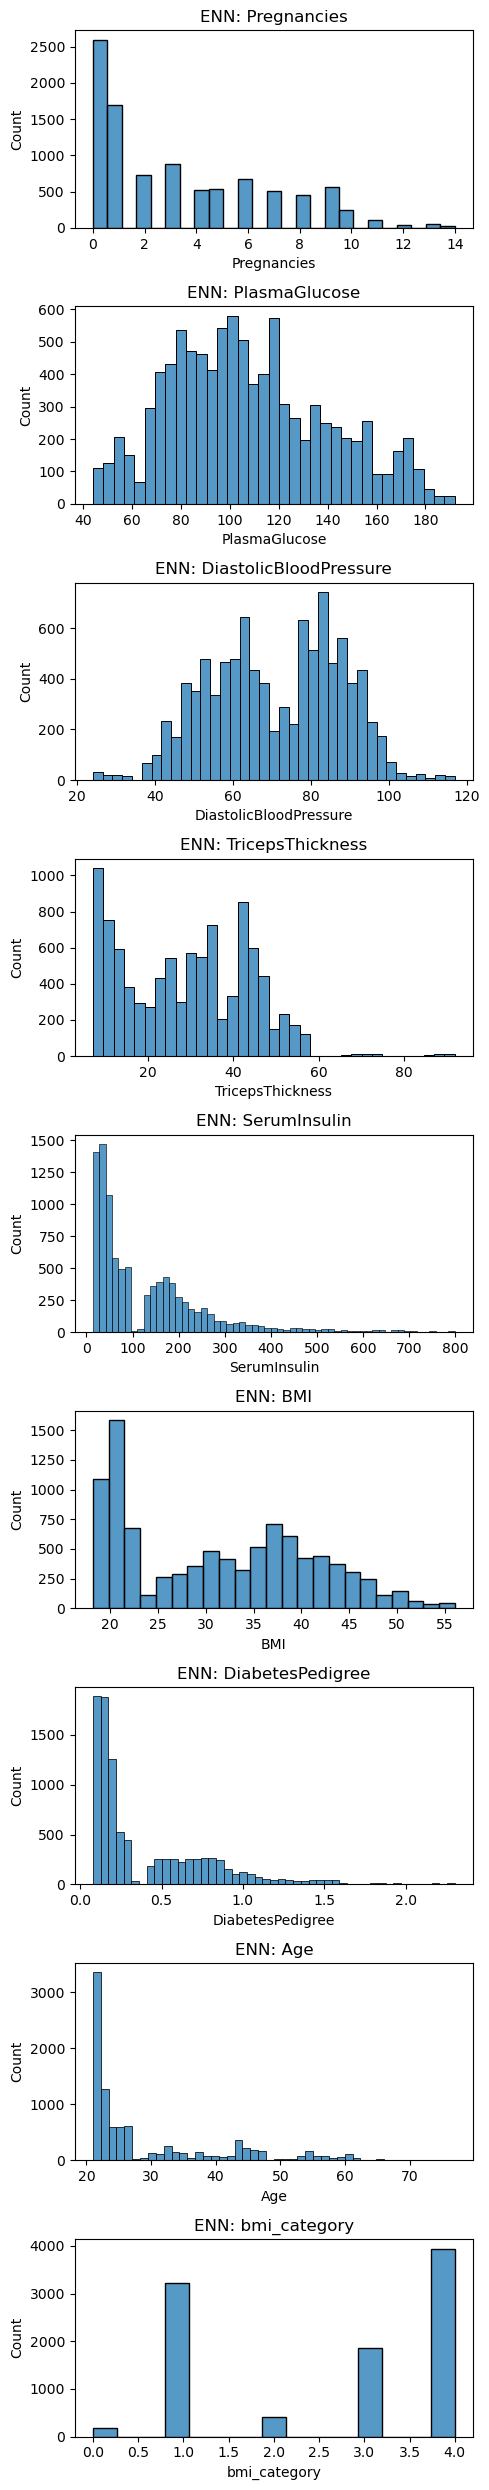

In [150]:
# Verification of the data distributions for the under-sampled dataset
fig, axes = plt.subplots(nrows = len(X_enn_train.columns), ncols = 1, figsize = (5, 25))

for i, col in enumerate(X_enn_train.columns):
    sns.histplot(data = X_enn_train, x = col, multiple = "stack", ax = axes[i])
    axes[i].set_title(f"ENN: {col}")

plt.tight_layout()
plt.show()

### **Feature Engineering 4: Over-sampling & under-sampling using SMOTE & ENN**

* Combining SMOTE & ENN techniques to address the classes imbalance.

In [ ]:
# Application of SMOTE (over-sampling) & ENN (under-sampling) methods on the base datasets
X_smoteen_train, y_smoteen_train = enn.fit_resample(X_smote_train, y_smote_train)
X_smoteen_train.describe()

Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  \
count  14384.000000   14384.000000            14384.000000      14384.000000   
mean       3.409622     109.393632               71.797066         29.368117   
std        3.233680      31.570209               15.900171         14.569394   
min        0.000000      44.000000               24.000000          7.000000   
25%        1.000000      87.000000               60.000000         16.000000   
50%        3.000000     106.000000               73.000000         31.000000   
75%        6.000000     129.000000               84.000000         42.000000   
max       14.000000     192.000000              117.000000         92.000000   

       SerumInsulin           BMI  DiabetesPedigree          Age  bmi_category  
count  14384.000000  14384.000000      14384.000000  14384.00000  14384.000000  
mean     148.059441     31.980015          0.419190     31.62354      2.703490  
std      139.638047      9.310480          0.373974     12.62215      1.293327  
min       14.000000     18.200512          0.078044     21.00000      0.000000  
25%       44.000000     21.697753          0.146369     22.00000      1.000000  
50%       88.000000     32.275197          0.236740     25.00000      3.000000  
75%      205.000000     39.080408          0.642878     42.00000      4.000000  
max      799.000000     56.034628          2.301594     77.00000      4.000000

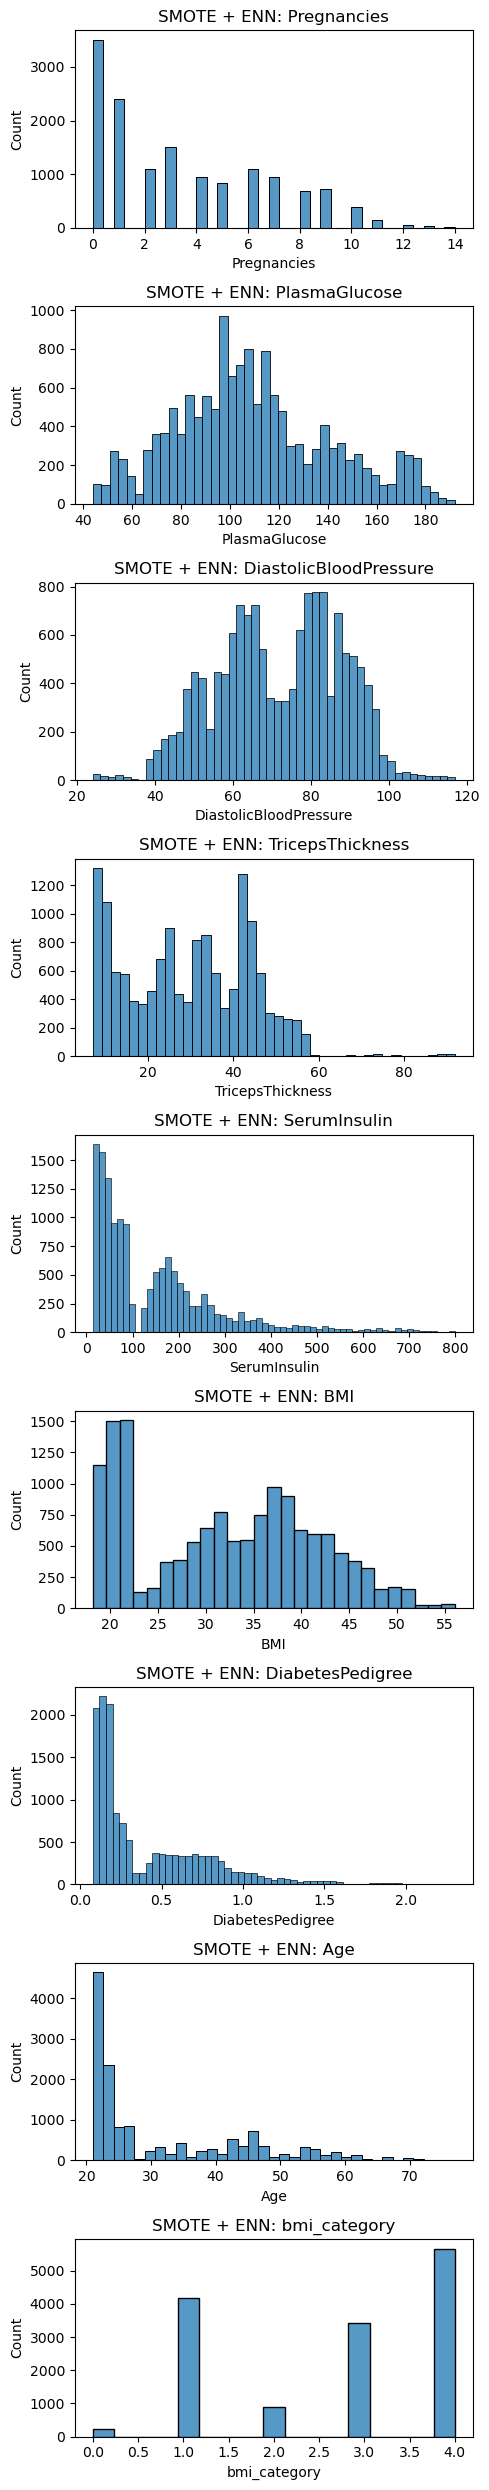

In [148]:
# Verification of the data distributions for the over-sampled & under-sampled dataset
fig, axes = plt.subplots(nrows = len(X_smoteen_train.columns), ncols = 1, figsize = (5, 25))

for i, col in enumerate(X_smoteen_train.columns):
    sns.histplot(data = X_smoteen_train, x = col, multiple = "stack", ax = axes[i])
    axes[i].set_title(f"SMOTE + ENN: {col}")

plt.tight_layout()
plt.show()

### **Feature Engineering 5: Over-sampling using ADASYN**

* Usage of another over-sampling technique, giving us more choice of adjusting to the class imbalance present in the dataset.

In [88]:
# Application of ADASYN under-sampling method on the base datasets
adasyn = ADASYN(random_state = 0)
X_adasyn_train, y_adasyn_train = adasyn.fit_resample(X_train, y_train)
X_adasyn_train.describe()

Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  \
count  16314.000000    16314.00000            16314.000000      16314.000000   
mean       3.563136      108.42393               71.703874         29.142883   
std        3.202761       32.02145               16.099405         14.438883   
min        0.000000       44.00000               24.000000          7.000000   
25%        1.000000       85.00000               60.000000         15.000000   
50%        3.000000      106.00000               73.000000         30.000000   
75%        6.000000      130.00000               85.000000         42.000000   
max       14.000000      192.00000              117.000000         92.000000   

       SerumInsulin           BMI  DiabetesPedigree           Age  \
count  16314.000000  16314.000000      16314.000000  16314.000000   
mean     148.388685     32.115358          0.426676     30.224654   
std      138.410307      9.265501          0.378063     12.009436   
min       14.000000     18.200512          0.078044     21.000000   
25%       42.000000     21.929404          0.146564     22.000000   
50%       91.000000     32.199945          0.240366     24.000000   
75%      207.750000     39.096618          0.657380     37.000000   
max      799.000000     56.034628          2.301594     77.000000   

       bmi_category  
count  16314.000000  
mean       2.716011  
std        1.275251  
min        0.000000  
25%        1.000000  
50%        3.000000  
75%        4.000000  
max        4.000000

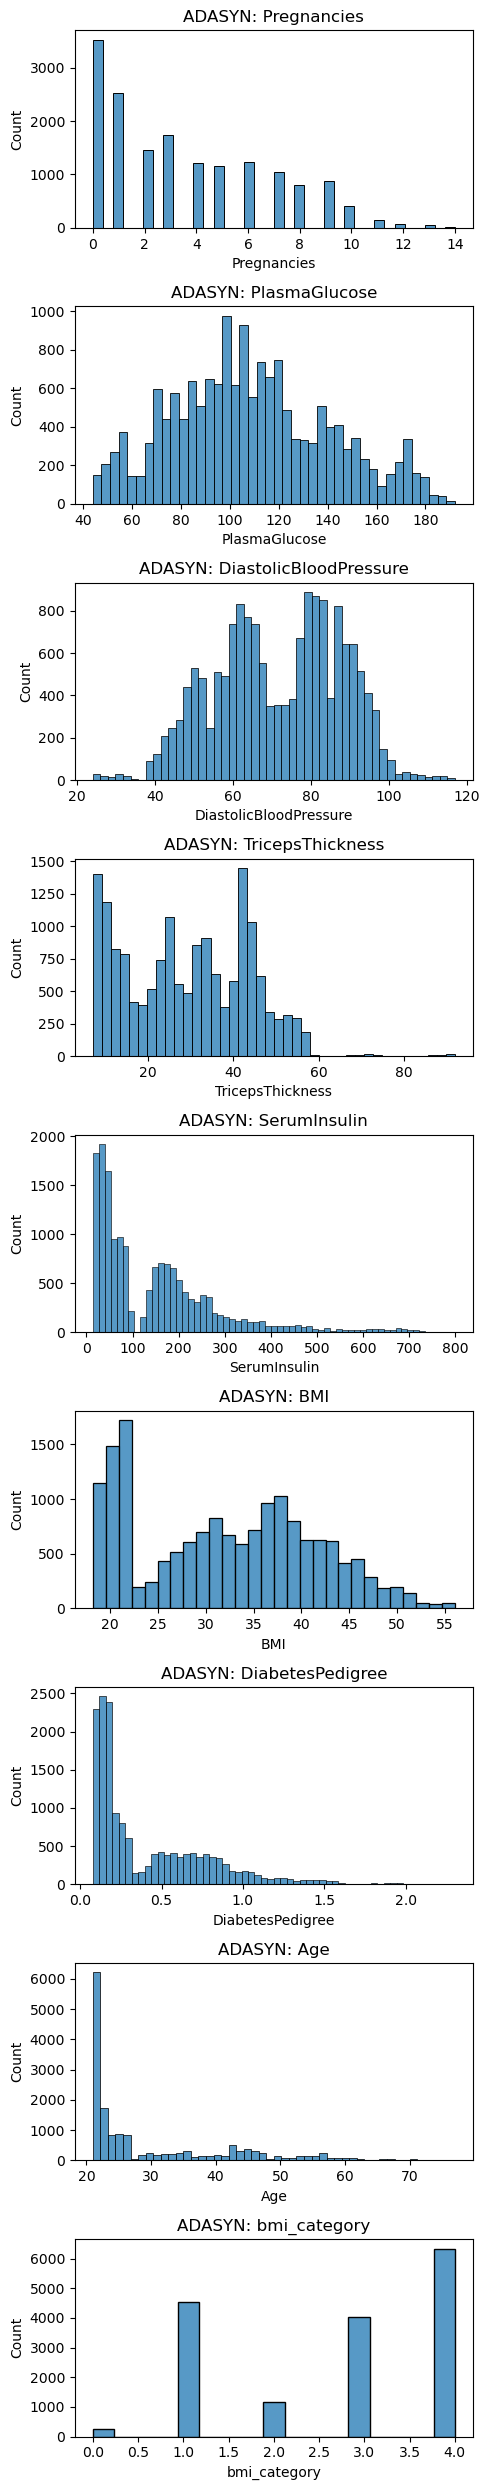

In [69]:
# Verification of the data distributions for the under-sampled dataset
fig, axes = plt.subplots(nrows = len(X_adasyn_train.columns), ncols = 1, figsize = (5, 25))

for i, col in enumerate(X_adasyn_train.columns):
    sns.histplot(data = X_adasyn_train, x = col, multiple = "stack", ax = axes[i])
    axes[i].set_title(f"ADASYN: {col}")

plt.tight_layout()
plt.show()

### **Feature Engineering 5: Under-sampling using TomekLinks**

* Usage of another under-sampling technique, giving us more choice of adjusting to the class imbalance present in the dataset.

In [99]:
# Application of TomekLinks under-sampling method on the base datasets
tomeklinks = TomekLinks()
X_tomek_train, y_tomek_train = tomeklinks.fit_resample(X_train, y_train)
X_tomek_train.describe()

Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  \
count  11508.000000   11508.000000            11508.000000      11508.000000   
mean       3.223497     107.655631               71.264946         28.796055   
std        3.382347      31.995522               16.765123         14.643708   
min        0.000000      44.000000               24.000000          7.000000   
25%        0.000000      84.000000               58.000000         15.000000   
50%        2.000000     104.000000               72.000000         30.000000   
75%        6.000000     129.000000               85.000000         41.000000   
max       14.000000     192.000000              117.000000         92.000000   

       SerumInsulin           BMI  DiabetesPedigree           Age  \
count  11508.000000  11508.000000      11508.000000  11508.000000   
mean     136.662061     31.400796          0.403211     30.150330   
std      132.689844      9.775918          0.382147     12.091752   
min       14.000000     18.200512          0.078044     21.000000   
25%       38.000000     21.231049          0.138130     22.000000   
50%       82.000000     31.529414          0.200843     24.000000   
75%      194.000000     39.176089          0.626251     35.000000   
max      799.000000     56.034628          2.301594     77.000000   

       bmi_category  
count  11508.000000  
mean       2.649896  
std        1.366727  
min        0.000000  
25%        1.000000  
50%        3.000000  
75%        4.000000  
max        4.000000

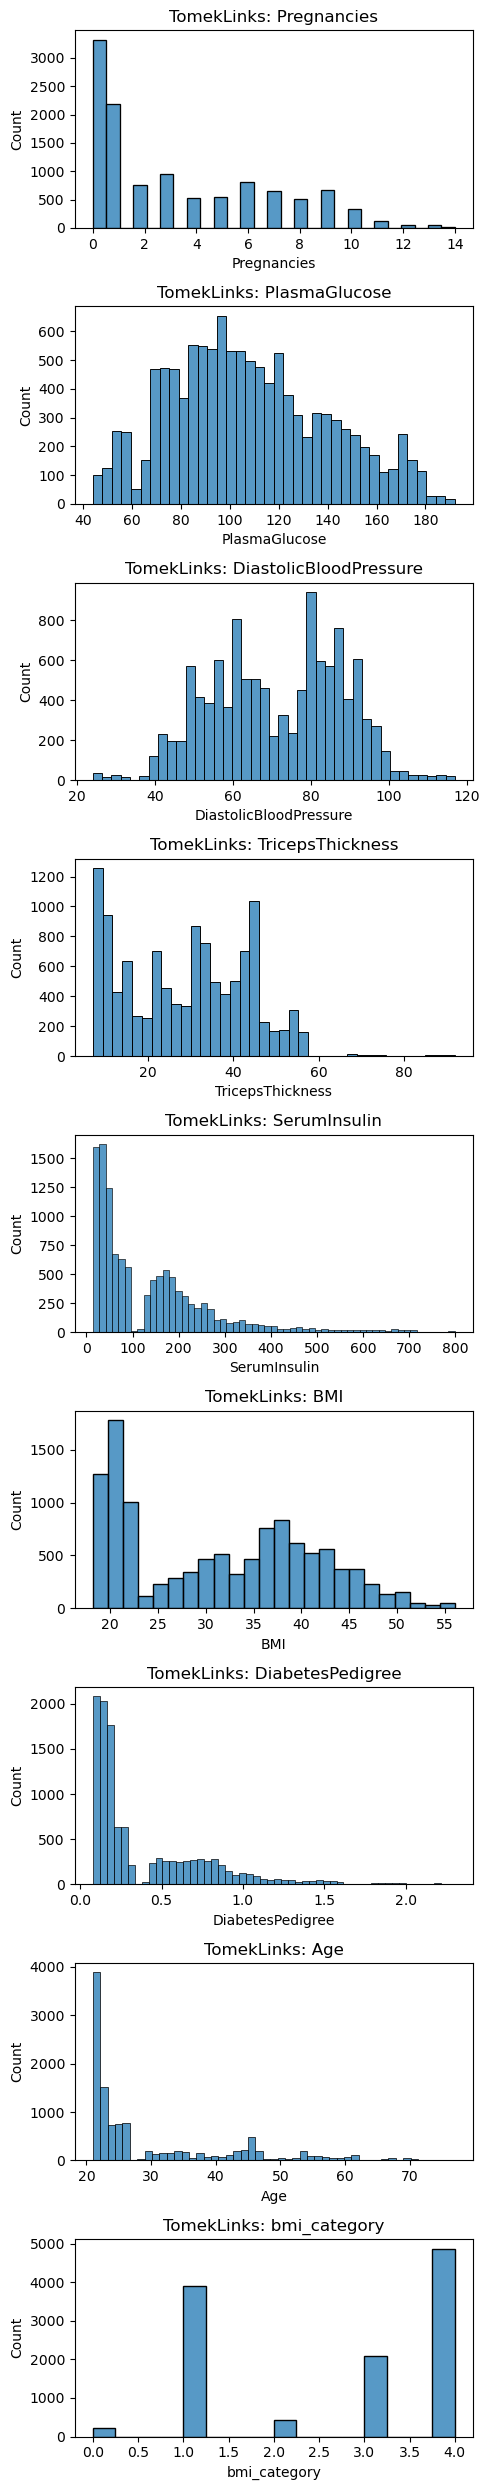

In [90]:
# Verification of the data distributions for the under-sampled dataset
fig, axes = plt.subplots(nrows = len(X_tomeklinks_train.columns), ncols = 1, figsize = (5, 25))

for i, col in enumerate(X_tomeklinks_train.columns):
    sns.histplot(data = X_tomeklinks_train, x = col, multiple = "stack", ax = axes[i])
    axes[i].set_title(f"TomekLinks: {col}")

plt.tight_layout()
plt.show()

### **Feature Engineering 6: Over-sampling & under-sampling using ADASYN & TomekLinks**

* Combination of ADASYN & TomekLinks in order to balance some additional noise that could've been introducted due to simply oversampling the dataset.

In [91]:
# Application of ADASYN (over-sampling) & TomekLinks (under-sampling) methods on the base datasets
X_adatomek_train, y_adatomek_train = enn.fit_resample(X_adasyn_train, y_adasyn_train)
X_adatomek_train.describe()

Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  \
count  15041.000000   15041.000000            15041.000000      15041.000000   
mean       3.469783     108.138555               71.609600         29.021608   
std        3.220555      31.986487               16.108252         14.386094   
min        0.000000      44.000000               24.000000          7.000000   
25%        1.000000      85.000000               59.000000         15.000000   
50%        3.000000     105.000000               72.000000         30.000000   
75%        6.000000     130.000000               85.000000         42.000000   
max       14.000000     192.000000              117.000000         92.000000   

       SerumInsulin           BMI  DiabetesPedigree           Age  \
count   15041.00000  15041.000000      15041.000000  15041.000000   
mean      145.65973     31.976985          0.421818     30.137291   
std       137.48016      9.285172          0.375230     11.946522   
min        14.00000     18.200512          0.078044     21.000000   
25%        41.00000     21.766315          0.145896     22.000000   
50%        88.00000     32.084199          0.237430     24.000000   
75%       204.00000     39.066178          0.650440     37.000000   
max       799.00000     56.034628          2.301594     77.000000   

       bmi_category  
count  15041.000000  
mean       2.702014  
std        1.285311  
min        0.000000  
25%        1.000000  
50%        3.000000  
75%        4.000000  
max        4.000000

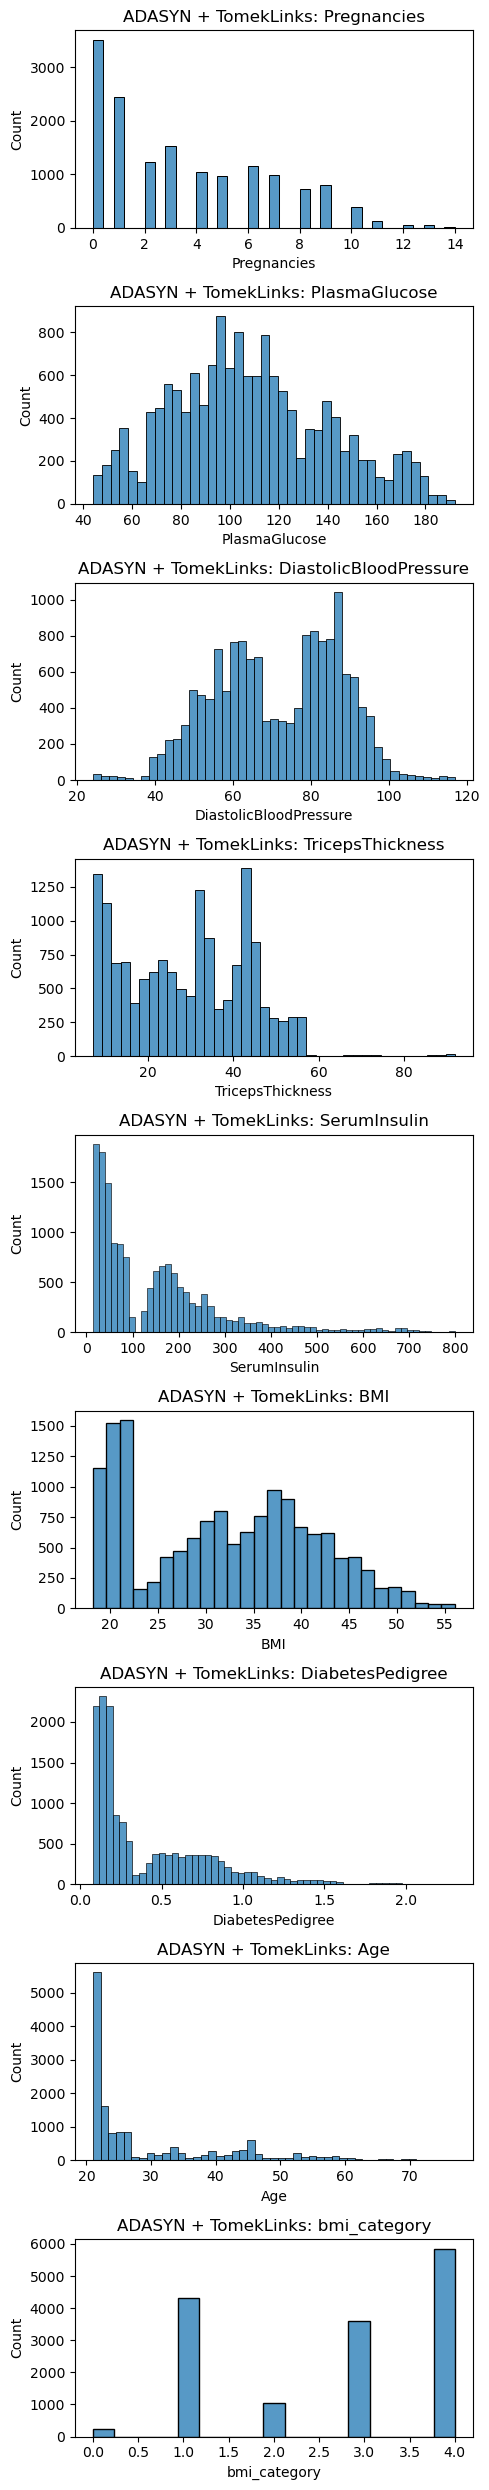

In [93]:
# Verification of the data distributions for the over-sampled & under-sampled dataset
fig, axes = plt.subplots(nrows = len(X_adatomek_train.columns), ncols = 1, figsize = (5, 25))

for i, col in enumerate(X_adatomek_train.columns):
    sns.histplot(data = X_adatomek_train, x = col, multiple = "stack", ax = axes[i])
    axes[i].set_title(f"ADASYN + TomekLinks: {col}")

plt.tight_layout()
plt.show()

---
# **5. MODELS TRAINING & EVALUATION**
---

## **5.1 Model 1: Random Forest**

### **5.1.0 Random Forest - base case training**

In [94]:
# Training
rf_f0 = RandomForestClassifier(random_state = 0)
rf_f0.fit(X_train, y_train)

# Predictions
rf_f0_prediction = rf_f0.predict(X_test)
rf_f0_pima_prediction = rf_f0.predict(X_pima)

# Results
model_performance_metrics(y_test, rf_f0_prediction, y_pima, rf_f0_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2000
           1       0.92      0.89      0.90      1000

    accuracy                           0.94      3000
   macro avg       0.93      0.92      0.93      3000
weighted avg       0.94      0.94      0.94      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.76      0.50      0.60       262
           1       0.40      0.68      0.50       130

    accuracy                           0.56       392
   macro avg       0.58      0.59      0.55       392
weighted avg       0.64      0.56      0.57       392



AUC-ROC score - test dataset: 0.92350


AUC-ROC score - PIMA Indian dataset: 0.58846


Confusion Matrix - test dataset:
[[1924   76]
 [ 115  885]]


Confusion Matrix - PIMA Indian dataset:
[[131 131]
 [ 42  88]]


### **5.1.1 Random Forest - SMOTE adjustment**

In [95]:
# Training
rf_f1 = RandomForestClassifier(random_state = 0)
rf_f1.fit(X_smote_train, y_smote_train)

# Predictions
rf_f1_prediction = rf_f1.predict(X_test)
rf_f1_pima_prediction = rf_f1.predict(X_pima)

# Results
model_performance_metrics(y_test, rf_f1_prediction, y_pima, rf_f1_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2000
           1       0.89      0.90      0.90      1000

    accuracy                           0.93      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.93      0.93      0.93      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.80      0.42      0.55       262
           1       0.40      0.79      0.54       130

    accuracy                           0.54       392
   macro avg       0.60      0.61      0.54       392
weighted avg       0.67      0.54      0.55       392



AUC-ROC score - test dataset: 0.92400


AUC-ROC score - PIMA Indian dataset: 0.60608


Confusion Matrix - test dataset:
[[1894  106]
 [  99  901]]


Confusion Matrix - PIMA Indian dataset:
[[110 152]
 [ 27 103]]


### **5.1.2 Random Forest - ENN adjustment**

In [96]:
# Training
rf_f2 = RandomForestClassifier(random_state = 0)
rf_f2.fit(X_enn_train, y_enn_train)

# Predictions
rf_f2_prediction = rf_f2.predict(X_test)
rf_f2_pima_prediction = rf_f2.predict(X_pima)

# Results
model_performance_metrics(y_test, rf_f2_prediction, y_pima, rf_f2_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      2000
           1       0.84      0.93      0.88      1000

    accuracy                           0.92      3000
   macro avg       0.90      0.92      0.91      3000
weighted avg       0.92      0.92      0.92      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.80      0.39      0.52       262
           1       0.39      0.80      0.53       130

    accuracy                           0.53       392
   macro avg       0.60      0.59      0.53       392
weighted avg       0.66      0.53      0.52       392



AUC-ROC score - test dataset: 0.92225


AUC-ROC score - PIMA Indian dataset: 0.59466


Confusion Matrix - test dataset:
[[1825  175]
 [  68  932]]


Confusion Matrix - PIMA Indian dataset:
[[102 160]
 [ 26 104]]


### **5.1.3 Random Forest - SMOTE + ENN adjustment**

In [97]:
# Training
rf_f3 = RandomForestClassifier(random_state = 0)
rf_f3.fit(X_smoteen_train, y_smoteen_train)

# Predictions
rf_f3_prediction = rf_f3.predict(X_test)
rf_f3_pima_prediction = rf_f3.predict(X_pima)

# Results
model_performance_metrics(y_test, rf_f3_prediction, y_pima, rf_f3_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2000
           1       0.93      0.84      0.88      1000

    accuracy                           0.93      3000
   macro avg       0.93      0.91      0.92      3000
weighted avg       0.93      0.93      0.93      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.80      0.46      0.58       262
           1       0.41      0.76      0.54       130

    accuracy                           0.56       392
   macro avg       0.60      0.61      0.56       392
weighted avg       0.67      0.56      0.57       392



AUC-ROC score - test dataset: 0.90600


AUC-ROC score - PIMA Indian dataset: 0.61169


Confusion Matrix - test dataset:
[[1934   66]
 [ 155  845]]


Confusion Matrix - PIMA Indian dataset:
[[121 141]
 [ 31  99]]


### **5.1.4 Random Forest - ADASYN adjustment**

In [98]:
# Training
rf_f4 = RandomForestClassifier(random_state = 0)
rf_f4.fit(X_adasyn_train, y_adasyn_train)

# Predictions
rf_f4_prediction = rf_f4.predict(X_test)
rf_f4_pima_prediction = rf_f4.predict(X_pima)

# Results
model_performance_metrics(y_test, rf_f4_prediction, y_pima, rf_f4_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2000
           1       0.88      0.91      0.89      1000

    accuracy                           0.93      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.93      0.93      0.93      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.77      0.38      0.51       262
           1       0.38      0.77      0.51       130

    accuracy                           0.51       392
   macro avg       0.58      0.58      0.51       392
weighted avg       0.64      0.51      0.51       392



AUC-ROC score - test dataset: 0.92325


AUC-ROC score - PIMA Indian dataset: 0.57546


Confusion Matrix - test dataset:
[[1871  129]
 [  89  911]]


Confusion Matrix - PIMA Indian dataset:
[[100 162]
 [ 30 100]]


### **5.1.5 Random Forest - TomekLinks adjustment**

In [100]:
# Training
rf_f5 = RandomForestClassifier(random_state = 0)
rf_f5.fit(X_tomek_train, y_tomek_train)

# Predictions
rf_f5_prediction = rf_f5.predict(X_test)
rf_f5_pima_prediction = rf_f5.predict(X_pima)

# Results
model_performance_metrics(y_test, rf_f5_prediction, y_pima, rf_f5_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2000
           1       0.91      0.90      0.90      1000

    accuracy                           0.94      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.94      0.93      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.76      0.44      0.56       262
           1       0.39      0.72      0.51       130

    accuracy                           0.54       392
   macro avg       0.58      0.58      0.53       392
weighted avg       0.64      0.54      0.54       392



AUC-ROC score - test dataset: 0.92525


AUC-ROC score - PIMA Indian dataset: 0.58291


Confusion Matrix - test dataset:
[[1909   91]
 [ 104  896]]


Confusion Matrix - PIMA Indian dataset:
[[116 146]
 [ 36  94]]


### **5.1.6 Random Forest - ADASYN + TomekLinks adjustment**

In [101]:
# Training
rf_f6 = RandomForestClassifier(random_state = 0)
rf_f6.fit(X_adatomek_train, y_adatomek_train)

# Predictions
rf_f6_prediction = rf_f6.predict(X_test)
rf_f6_pima_prediction = rf_f6.predict(X_pima)

# Results
model_performance_metrics(y_test, rf_f6_prediction, y_pima, rf_f6_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2000
           1       0.90      0.89      0.89      1000

    accuracy                           0.93      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.93      0.93      0.93      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.78      0.41      0.54       262
           1       0.39      0.77      0.52       130

    accuracy                           0.53       392
   macro avg       0.59      0.59      0.53       392
weighted avg       0.65      0.53      0.53       392



AUC-ROC score - test dataset: 0.91975


AUC-ROC score - PIMA Indian dataset: 0.59072


Confusion Matrix - test dataset:
[[1897  103]
 [ 109  891]]


Confusion Matrix - PIMA Indian dataset:
[[108 154]
 [ 30 100]]


### **5.1.7 Random Forest - hyperparameter tuning for the SMOTE & ENN adjusted sets**

In [ ]:
# Setting up a parameter grid with parameters to be tested for Random Forest
rf_param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "criterion": ["gini", "entropy", "log_loss"], 
    "max_depth": [None, 2, 3, 4, 6, 8, 10, 15, 20, 30],
    "max_features": [None, "sqrt", "log2"],
    "min_samples_split": [2, 4, 6, 8, 10, 15, 20, 30],
    "min_samples_leaf": [1, 2, 4, 6, 8, 10, 15, 20, 30, 50],
    "bootstrap": [True, False],
    "class_weight": [None, "balanced", "balanced_subsample"]
}

# Model preparation and setup of Randomized search - Grid search takes too much computing power / time for the number of specified features, therefore it is less adapted in our case
rf_h1 = RandomForestClassifier(random_state = 0)
rf_h1_param_search = RandomizedSearchCV(rf_h1, param_distributions = rf_param_grid,
    random_state = 0,
    n_iter = 100,
    scoring = "accuracy",
    cv = 5,
    n_jobs = 12)

rf_h1_param_search.fit(X_smoteen_train, y_smoteen_train)

rf_h1_best_parameters = rf_h1_param_search.best_params_

# Hyperparameter testing results (based on accuracy)
print("Best hyperparameters to choose: ", rf_h1_param_search.best_params_)

Best hyperparameters to choose:  {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': False}


In [103]:
# Training our Random Forest using previously found parameters
rf_final1 = RandomForestClassifier(random_state = 0,
    n_estimators = rf_h1_best_parameters["n_estimators"],
    criterion = rf_h1_best_parameters["criterion"],
    max_depth = rf_h1_best_parameters["max_depth"],
    max_features = rf_h1_best_parameters["max_features"],
    min_samples_split = rf_h1_best_parameters["min_samples_split"],
    min_samples_leaf = rf_h1_best_parameters["min_samples_leaf"],
    bootstrap = rf_h1_best_parameters["bootstrap"],
    class_weight = rf_h1_best_parameters["class_weight"])

rf_final1.fit(X_smoteen_train, y_smoteen_train)

# Predictions
rf_final1_prediction = rf_final1.predict(X_test)
rf_final1_pima_prediction = rf_final1.predict(X_pima)

# Results
model_performance_metrics(y_test, rf_final1_prediction, y_pima, rf_final1_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2000
           1       0.93      0.84      0.88      1000

    accuracy                           0.92      3000
   macro avg       0.92      0.90      0.91      3000
weighted avg       0.92      0.92      0.92      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.78      0.47      0.59       262
           1       0.41      0.74      0.53       130

    accuracy                           0.56       392
   macro avg       0.60      0.60      0.56       392
weighted avg       0.66      0.56      0.57       392



AUC-ROC score - test dataset: 0.90200


AUC-ROC score - PIMA Indian dataset: 0.60396


Confusion Matrix - test dataset:
[[1934   66]
 [ 163  837]]


Confusion Matrix - PIMA Indian dataset:
[[123 139]
 [ 34  96]]


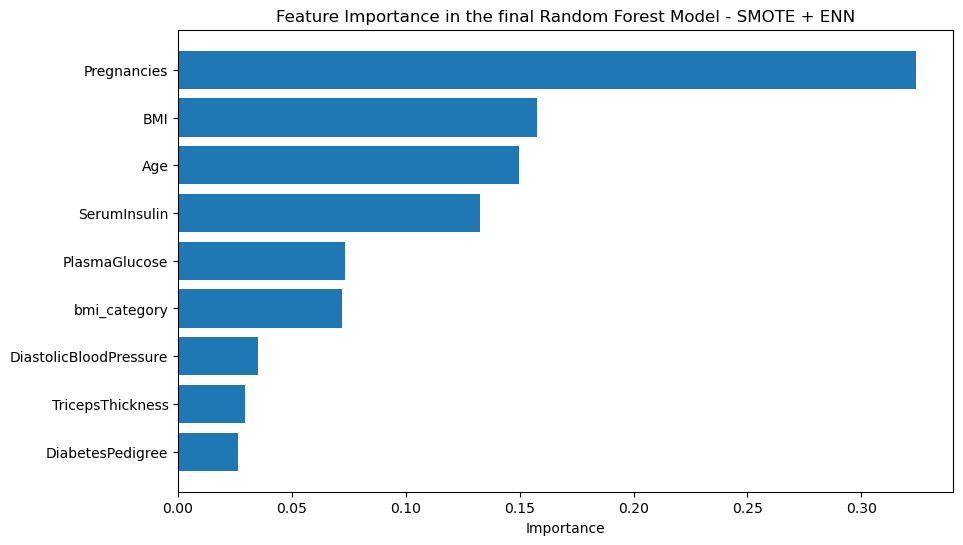

In [105]:
# Random Forest features importance score plot
rf_final1_importance = rf_final1.feature_importances_
rf_final1_feature = np.argsort(rf_final1_importance)

plt.figure(figsize = (10, 6))
plt.title("Feature Importance in the final Random Forest Model - SMOTE + ENN")
plt.barh(range(X.shape[1]), rf_final1_importance[rf_final1_feature], align = "center")
plt.yticks(range(X.shape[1]), np.array(X.columns)[rf_final1_feature])
plt.xlabel("Importance")
plt.show()

### **5.1.8 Random Forest - hyperparameter tuning for the ADASYN & TomekLinks adjusted sets**

In [106]:
# Model preparation and setup of Randomized search - Grid search takes too much computing power / time for the number of specified features, therefore it is less adapted in our case
rf_h2 = RandomForestClassifier(random_state = 0)
rf_h2_param_search = RandomizedSearchCV(rf_h2, param_distributions = rf_param_grid,
    random_state = 0,
    n_iter = 100,
    scoring = "accuracy",
    cv = 5,
    n_jobs = 12)

rf_h2_param_search.fit(X_adatomek_train, y_adatomek_train)

rf_h2_best_parameters = rf_h2_param_search.best_params_

# Hyperparameter testing results (based on accuracy)
print("Best hyperparameters to choose: ", rf_h2_param_search.best_params_)

Best hyperparameters to choose:  {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': False}


In [107]:
# Training our Random Forest using previously found parameters
rf_final2 = RandomForestClassifier(random_state = 0,
    n_estimators = rf_h2_best_parameters["n_estimators"],
    criterion = rf_h2_best_parameters["criterion"],
    max_depth = rf_h2_best_parameters["max_depth"],
    max_features = rf_h2_best_parameters["max_features"],
    min_samples_split = rf_h2_best_parameters["min_samples_split"],
    min_samples_leaf = rf_h2_best_parameters["min_samples_leaf"],
    bootstrap = rf_h2_best_parameters["bootstrap"],
    class_weight = rf_h2_best_parameters["class_weight"])

rf_final2.fit(X_adatomek_train, y_adatomek_train)

# Predictions
rf_final2_prediction = rf_final2.predict(X_test)
rf_final2_pima_prediction = rf_final2.predict(X_pima)

# Results
model_performance_metrics(y_test, rf_final2_prediction, y_pima, rf_final2_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2000
           1       0.90      0.88      0.89      1000

    accuracy                           0.93      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.93      0.93      0.93      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.77      0.39      0.52       262
           1       0.39      0.77      0.51       130

    accuracy                           0.52       392
   macro avg       0.58      0.58      0.52       392
weighted avg       0.65      0.52      0.52       392



AUC-ROC score - test dataset: 0.91525


AUC-ROC score - PIMA Indian dataset: 0.58118


Confusion Matrix - test dataset:
[[1901   99]
 [ 120  880]]


Confusion Matrix - PIMA Indian dataset:
[[103 159]
 [ 30 100]]


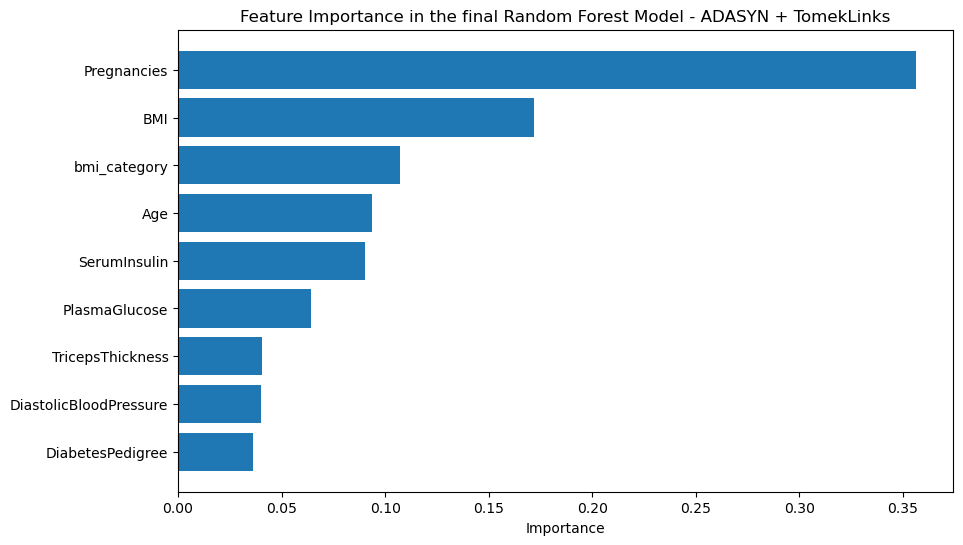

In [108]:
# Random Forest features importance score plot
rf_final2_importance = rf_final2.feature_importances_
rf_final2_feature = np.argsort(rf_final2_importance)

plt.figure(figsize = (10, 6))
plt.title("Feature Importance in the final Random Forest Model - ADASYN + TomekLinks")
plt.barh(range(X.shape[1]), rf_final2_importance[rf_final2_feature], align = "center")
plt.yticks(range(X.shape[1]), np.array(X.columns)[rf_final2_feature])
plt.xlabel("Importance")
plt.show()

---
## **5.2 Model 2: XGBoost**

### **5.2.0 XGBoost - base case training**

In [114]:
# Training
xgb_f0 = XGBClassifier(random_state = 0)
xgb_f0.fit(X_train, y_train)

# Predictions
xgb_f0_prediction = xgb_f0.predict(X_test)
xgb_f0_pima_prediction = xgb_f0.predict(X_pima)

# Results
model_performance_metrics(y_test, xgb_f0_prediction, y_pima, xgb_f0_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2000
           1       0.94      0.93      0.93      1000

    accuracy                           0.96      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.96      0.96      0.96      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.75      0.55      0.63       262
           1       0.41      0.63      0.50       130

    accuracy                           0.57       392
   macro avg       0.58      0.59      0.56       392
weighted avg       0.64      0.57      0.59       392



AUC-ROC score - test dataset: 0.94800


AUC-ROC score - PIMA Indian dataset: 0.58829


Confusion Matrix - test dataset:
[[1942   58]
 [  75  925]]


Confusion Matrix - PIMA Indian dataset:
[[143 119]
 [ 48  82]]


### **5.2.1 XGBoost - SMOTE adjustment**

In [115]:
# Training
xgb_f1 = XGBClassifier(random_state = 0)
xgb_f1.fit(X_smote_train, y_smote_train)

# Predictions
xgb_f1_prediction = xgb_f1.predict(X_test)
xgb_f1_pima_prediction = xgb_f1.predict(X_pima)

# Results
model_performance_metrics(y_test, xgb_f1_prediction, y_pima, xgb_f1_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2000
           1       0.92      0.94      0.93      1000

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.74      0.40      0.52       262
           1       0.37      0.72      0.49       130

    accuracy                           0.50       392
   macro avg       0.55      0.56      0.50       392
weighted avg       0.62      0.50      0.51       392



AUC-ROC score - test dataset: 0.94825


AUC-ROC score - PIMA Indian dataset: 0.55617


Confusion Matrix - test dataset:
[[1923   77]
 [  65  935]]


Confusion Matrix - PIMA Indian dataset:
[[104 158]
 [ 37  93]]


### **5.2.2 XGBoost - ENN adjustment**

In [116]:
# Training
xgb_f2 = XGBClassifier(random_state = 0)
xgb_f2.fit(X_enn_train, y_enn_train)

# Predictions
xgb_f2_prediction = xgb_f2.predict(X_test)
xgb_f2_pima_prediction = xgb_f2.predict(X_pima)

# Results
model_performance_metrics(y_test, xgb_f2_prediction, y_pima, xgb_f2_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2000
           1       0.87      0.96      0.91      1000

    accuracy                           0.94      3000
   macro avg       0.93      0.94      0.93      3000
weighted avg       0.94      0.94      0.94      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.74      0.41      0.53       262
           1       0.37      0.71      0.49       130

    accuracy                           0.51       392
   macro avg       0.56      0.56      0.51       392
weighted avg       0.62      0.51      0.51       392



AUC-ROC score - test dataset: 0.94400


AUC-ROC score - PIMA Indian dataset: 0.55804


Confusion Matrix - test dataset:
[[1862  138]
 [  43  957]]


Confusion Matrix - PIMA Indian dataset:
[[107 155]
 [ 38  92]]


### **5.2.3 XGBoost - SMOTE + ENN adjustment**

In [117]:
# Training
xgb_f3 = XGBClassifier(random_state = 0)
xgb_f3.fit(X_smoteen_train, y_smoteen_train)

# Predictions
xgb_f3_prediction = xgb_f3.predict(X_test)
xgb_f3_pima_prediction = xgb_f3.predict(X_pima)

# Results
model_performance_metrics(y_test, xgb_f3_prediction, y_pima, xgb_f3_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2000
           1       0.96      0.88      0.92      1000

    accuracy                           0.95      3000
   macro avg       0.95      0.93      0.94      3000
weighted avg       0.95      0.95      0.95      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.75      0.41      0.53       262
           1       0.38      0.73      0.50       130

    accuracy                           0.52       392
   macro avg       0.57      0.57      0.51       392
weighted avg       0.63      0.52      0.52       392



AUC-ROC score - test dataset: 0.92875


AUC-ROC score - PIMA Indian dataset: 0.56958


Confusion Matrix - test dataset:
[[1959   41]
 [ 122  878]]


Confusion Matrix - PIMA Indian dataset:
[[107 155]
 [ 35  95]]


### **5.2.4 XGB - ADASYN adjustment**

In [118]:
# Training
xgb_f4 = XGBClassifier(random_state = 0)
xgb_f4.fit(X_adasyn_train, y_adasyn_train)

# Predictions
xgb_f4_prediction = xgb_f4.predict(X_test)
xgb_f4_pima_prediction = xgb_f4.predict(X_pima)

# Results
model_performance_metrics(y_test, xgb_f4_prediction, y_pima, xgb_f4_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2000
           1       0.91      0.94      0.92      1000

    accuracy                           0.95      3000
   macro avg       0.94      0.95      0.94      3000
weighted avg       0.95      0.95      0.95      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.72      0.31      0.43       262
           1       0.35      0.76      0.48       130

    accuracy                           0.46       392
   macro avg       0.54      0.53      0.46       392
weighted avg       0.60      0.46      0.45       392



AUC-ROC score - test dataset: 0.94600


AUC-ROC score - PIMA Indian dataset: 0.53344


Confusion Matrix - test dataset:
[[1910   90]
 [  63  937]]


Confusion Matrix - PIMA Indian dataset:
[[ 80 182]
 [ 31  99]]


### **5.2.5 XGBoost - TomekLinks adjustment**

In [119]:
# Training
xgb_f5 = XGBClassifier(random_state = 0)
xgb_f5.fit(X_tomek_train, y_tomek_train)

# Predictions
xgb_f5_prediction = xgb_f5.predict(X_test)
xgb_f5_pima_prediction = xgb_f5.predict(X_pima)

# Results
model_performance_metrics(y_test, xgb_f5_prediction, y_pima, xgb_f5_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2000
           1       0.93      0.94      0.93      1000

    accuracy                           0.96      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.96      0.96      0.96      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.76      0.45      0.57       262
           1       0.39      0.71      0.50       130

    accuracy                           0.54       392
   macro avg       0.57      0.58      0.54       392
weighted avg       0.64      0.54      0.55       392



AUC-ROC score - test dataset: 0.95050


AUC-ROC score - PIMA Indian dataset: 0.58095


Confusion Matrix - test dataset:
[[1932   68]
 [  65  935]]


Confusion Matrix - PIMA Indian dataset:
[[119 143]
 [ 38  92]]


### **5.2.6 XGBoost - ADASYN + TomekLinks adjustment**

In [120]:
# Training
xgb_f6 = XGBClassifier(random_state = 0)
xgb_f6.fit(X_adatomek_train, y_adatomek_train)

# Predictions
xgb_f6_prediction = xgb_f6.predict(X_test)
xgb_f6_pima_prediction = xgb_f6.predict(X_pima)

# Results
model_performance_metrics(y_test, xgb_f6_prediction, y_pima, xgb_f6_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2000
           1       0.92      0.93      0.92      1000

    accuracy                           0.95      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.95      0.95      0.95      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.72      0.36      0.48       262
           1       0.36      0.72      0.48       130

    accuracy                           0.48       392
   macro avg       0.54      0.54      0.48       392
weighted avg       0.60      0.48      0.48       392



AUC-ROC score - test dataset: 0.94300


AUC-ROC score - PIMA Indian dataset: 0.54093


Confusion Matrix - test dataset:
[[1922   78]
 [  75  925]]


Confusion Matrix - PIMA Indian dataset:
[[ 94 168]
 [ 36  94]]


### **5.1.8 XGBoost - hyperparameter tuning for the SMOTE & ENN adjusted sets**

In [125]:
# Setting up a parameter grid with parameters to be tested for Random Forest
xgb_param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1],
    "max_depth": [2, 4, 6, 8, 10],
    "min_child_weight": [0.5, 0.8, 1, 1.2, 1.5, 2],
    "max_delta_step": [0, 0.2, 0.4, 0.8, 1.2, 2, 5],
    "subsample": [0.2, 0.4, 0.6, 0.8, 1],
    "min_split_loss": [0, 1.2, 1.5, 2, 3],
    "tree_method": ["auto", "exact", "approx", "hist"],
    "scale_pos_weight": [1, 10, 100, 10000],
    "eval_metric": ["logloss", "auc"],
    "booster": ["gbtree", "gblinear", "dart"]
}

# Model preparation and setup of Randomized search - Grid search takes too much computing power / time for the number of specified features, therefore it is less adapted in our case
xgb_h1 = XGBClassifier(random_state = 0)
xgb_h1_param_search = RandomizedSearchCV(xgb_h1, param_distributions = xgb_param_grid,
    random_state = 0,
    n_iter = 100,
    scoring = "accuracy",
    cv = 5,
    n_jobs = 12)

xgb_h1_param_search.fit(X_smoteen_train, y_smoteen_train)

xgb_h1_best_parameters = xgb_h1_param_search.best_params_

# Hyperparameter testing results (based on accuracy)
print("Best hyperparameters to choose: ", xgb_h1_param_search.best_params_)

Best hyperparameters to choose:  {'tree_method': 'auto', 'subsample': 1, 'scale_pos_weight': 1, 'n_estimators': 500, 'min_split_loss': 0, 'min_child_weight': 2, 'max_depth': 6, 'max_delta_step': 1.2, 'learning_rate': 0.2, 'eval_metric': 'logloss', 'booster': 'dart'}


In [128]:
# Training our XGBoost using previously found parameters
xgb_final1 = XGBClassifier(random_state = 0,
    n_estimators = xgb_h1_best_parameters["n_estimators"],
    learning_rate = xgb_h1_best_parameters["learning_rate"],
    max_depth = xgb_h1_best_parameters["max_depth"],
    min_child_weight = xgb_h1_best_parameters["min_child_weight"],
    max_delta_step = xgb_h1_best_parameters["max_delta_step"],
    subsample = xgb_h1_best_parameters["subsample"],
    min_split_loss = xgb_h1_best_parameters["min_split_loss"],
    tree_method = xgb_h1_best_parameters["tree_method"],
    scale_pos_weight = xgb_h1_best_parameters["scale_pos_weight"],
    eval_metric = xgb_h1_best_parameters["eval_metric"],
    booster = xgb_h1_best_parameters["booster"])

xgb_final1.fit(X_smoteen_train, y_smoteen_train)

# Predictions
xgb_final1_prediction = xgb_final1.predict(X_test)
xgb_final1_pima_prediction = xgb_final1.predict(X_pima)

# Results
model_performance_metrics(y_test, xgb_final1_prediction, y_pima, xgb_final1_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2000
           1       0.95      0.88      0.91      1000

    accuracy                           0.94      3000
   macro avg       0.95      0.93      0.94      3000
weighted avg       0.94      0.94      0.94      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.75      0.42      0.54       262
           1       0.38      0.72      0.50       130

    accuracy                           0.52       392
   macro avg       0.57      0.57      0.52       392
weighted avg       0.63      0.52      0.53       392



AUC-ROC score - test dataset: 0.92875


AUC-ROC score - PIMA Indian dataset: 0.57146


Confusion Matrix - test dataset:
[[1951   49]
 [ 118  882]]


Confusion Matrix - PIMA Indian dataset:
[[110 152]
 [ 36  94]]


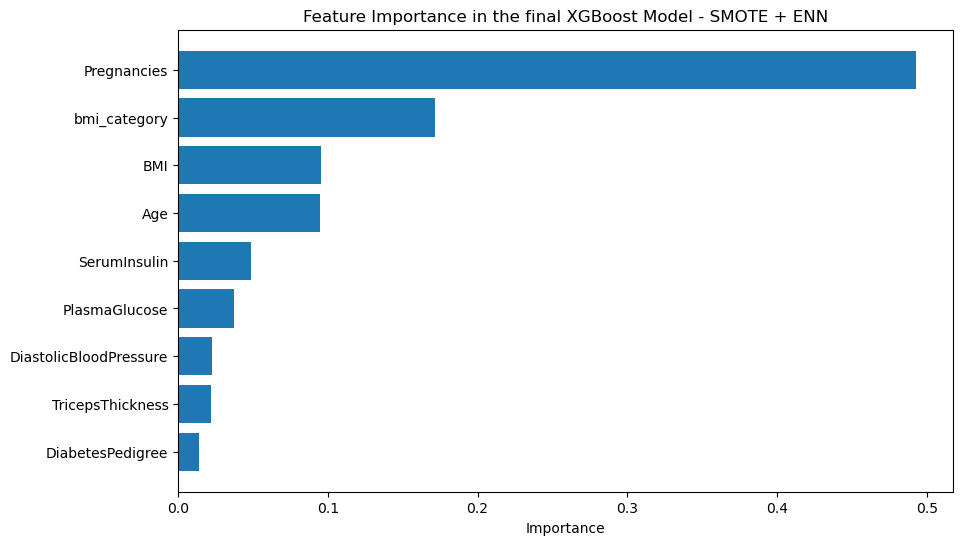

In [129]:
# XGBoost features importance score plot
xgb_final1_importance = xgb_final1.feature_importances_
xgb_final1_feature = np.argsort(xgb_final1_importance)

plt.figure(figsize = (10, 6))
plt.title("Feature Importance in the final XGBoost Model - SMOTE + ENN")
plt.barh(range(X.shape[1]), xgb_final1_importance[xgb_final1_feature], align = "center")
plt.yticks(range(X.shape[1]), np.array(X.columns)[xgb_final1_feature])
plt.xlabel("Importance")
plt.show()

### **5.2.8 XGBoost - hyperparameter tuning for the ADASYN & TomekLinks adjusted sets**

In [127]:
# Model preparation and setup of Randomized search - Grid search takes too much computing power / time for the number of specified features, therefore it is less adapted in our case
xgb_h2 = XGBClassifier(random_state = 0)
xgb_h2_param_search = RandomizedSearchCV(xgb_h2, param_distributions = xgb_param_grid,
    random_state = 0,
    n_iter = 100,
    scoring = "accuracy",
    cv = 5,
    n_jobs = 12)

xgb_h2_param_search.fit(X_adatomek_train, y_adatomek_train)

xgb_h2_best_parameters = xgb_h2_param_search.best_params_

# Hyperparameter testing results (based on accuracy)
print("Best hyperparameters to choose: ", xgb_h2_param_search.best_params_)

Best hyperparameters to choose:  {'tree_method': 'auto', 'subsample': 1, 'scale_pos_weight': 1, 'n_estimators': 500, 'min_split_loss': 0, 'min_child_weight': 2, 'max_depth': 6, 'max_delta_step': 1.2, 'learning_rate': 0.2, 'eval_metric': 'logloss', 'booster': 'dart'}


In [131]:
# Training our XGBoost using previously found parameters
xgb_final2 = XGBClassifier(random_state = 0,
    n_estimators = xgb_h2_best_parameters["n_estimators"],
    learning_rate = xgb_h2_best_parameters["learning_rate"],
    max_depth = xgb_h2_best_parameters["max_depth"],
    min_child_weight = xgb_h2_best_parameters["min_child_weight"],
    max_delta_step = xgb_h2_best_parameters["max_delta_step"],
    subsample = xgb_h2_best_parameters["subsample"],
    min_split_loss = xgb_h2_best_parameters["min_split_loss"],
    tree_method = xgb_h2_best_parameters["tree_method"],
    scale_pos_weight = xgb_h2_best_parameters["scale_pos_weight"],
    eval_metric = xgb_h2_best_parameters["eval_metric"],
    booster = xgb_h2_best_parameters["booster"])

xgb_final2.fit(X_adatomek_train, y_adatomek_train)

# Predictions
xgb_final2_prediction = xgb_final2.predict(X_test)
xgb_final2_pima_prediction = xgb_final2.predict(X_pima)

# Results
model_performance_metrics(y_test, xgb_final2_prediction, y_pima, xgb_final2_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2000
           1       0.93      0.92      0.92      1000

    accuracy                           0.95      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.95      0.95      0.95      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.73      0.35      0.47       262
           1       0.36      0.74      0.48       130

    accuracy                           0.48       392
   macro avg       0.55      0.54      0.48       392
weighted avg       0.61      0.48      0.48       392



AUC-ROC score - test dataset: 0.94350


AUC-ROC score - PIMA Indian dataset: 0.54480


Confusion Matrix - test dataset:
[[1926   74]
 [  76  924]]


Confusion Matrix - PIMA Indian dataset:
[[ 92 170]
 [ 34  96]]


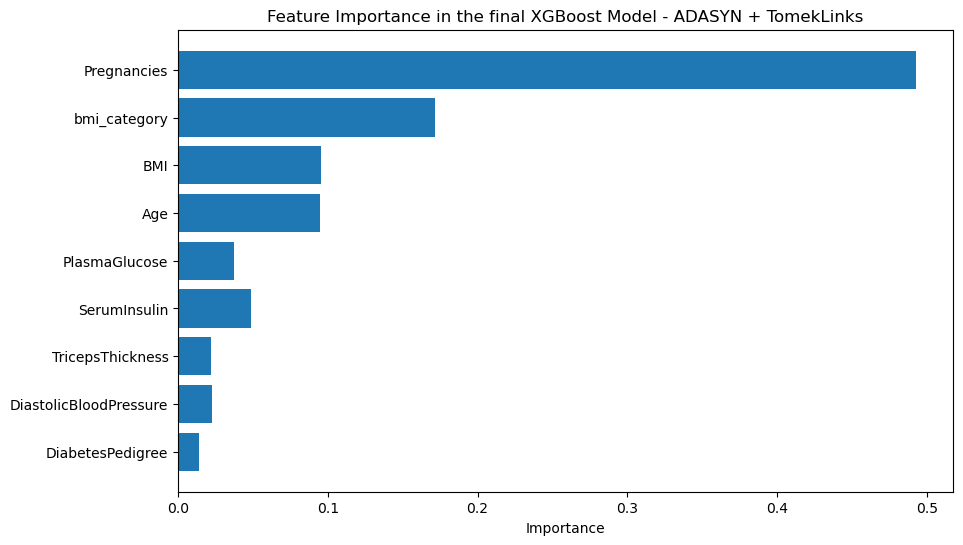

In [132]:
# XGBoost features importance score plot
xgb_final2_importance = xgb_final2.feature_importances_
xgb_final2_feature = np.argsort(xgb_final2_importance)

plt.figure(figsize = (10, 6))
plt.title("Feature Importance in the final XGBoost Model - ADASYN + TomekLinks")
plt.barh(range(X.shape[1]), xgb_final1_importance[xgb_final2_feature], align = "center")
plt.yticks(range(X.shape[1]), np.array(X.columns)[xgb_final2_feature])
plt.xlabel("Importance")
plt.show()

---
## **5.3 Model 3: Decision Tree**

### **5.3.0 Decision Tree - base case training**

In [133]:
# Training
dt_f0 = DecisionTreeClassifier(random_state = 0)
dt_f0.fit(X_train, y_train)

# Predictions
dt_f0_prediction = dt_f0.predict(X_test)
dt_f0_pima_prediction = dt_f0.predict(X_pima)

# Results
model_performance_metrics(y_test, dt_f0_prediction, y_pima, dt_f0_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2000
           1       0.84      0.84      0.84      1000

    accuracy                           0.89      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.89      0.89      0.89      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.80      0.55      0.65       262
           1       0.45      0.73      0.55       130

    accuracy                           0.61       392
   macro avg       0.63      0.64      0.60       392
weighted avg       0.69      0.61      0.62       392



AUC-ROC score - test dataset: 0.88225


AUC-ROC score - PIMA Indian dataset: 0.64019


Confusion Matrix - test dataset:
[[1839  161]
 [ 155  845]]


Confusion Matrix - PIMA Indian dataset:
[[144 118]
 [ 35  95]]


### **5.3.1 Decision Tree - SMOTE adjustment**

In [134]:
# Training
dt_f1 = DecisionTreeClassifier(random_state = 0)
dt_f1.fit(X_smote_train, y_smote_train)

# Predictions
dt_f1_prediction = dt_f1.predict(X_test)
dt_f1_pima_prediction = dt_f1.predict(X_pima)

# Results
model_performance_metrics(y_test, dt_f1_prediction, y_pima, dt_f1_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2000
           1       0.83      0.86      0.85      1000

    accuracy                           0.90      3000
   macro avg       0.88      0.89      0.88      3000
weighted avg       0.90      0.90      0.90      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.81      0.45      0.58       262
           1       0.42      0.79      0.55       130

    accuracy                           0.56       392
   macro avg       0.62      0.62      0.56       392
weighted avg       0.68      0.56      0.57       392



AUC-ROC score - test dataset: 0.88650


AUC-ROC score - PIMA Indian dataset: 0.62134


Confusion Matrix - test dataset:
[[1826  174]
 [ 140  860]]


Confusion Matrix - PIMA Indian dataset:
[[118 144]
 [ 27 103]]


### **5.3.2 Decision Tree - ENN adjustment**

In [135]:
# Training
dt_f2 = DecisionTreeClassifier(random_state = 0)
dt_f2.fit(X_enn_train, y_enn_train)

# Predictions
dt_f2_prediction = dt_f2.predict(X_test)
dt_f2_pima_prediction = dt_f2.predict(X_pima)

# Results
model_performance_metrics(y_test, dt_f2_prediction, y_pima, dt_f2_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      2000
           1       0.78      0.91      0.84      1000

    accuracy                           0.89      3000
   macro avg       0.87      0.89      0.88      3000
weighted avg       0.90      0.89      0.89      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.80      0.47      0.59       262
           1       0.42      0.76      0.54       130

    accuracy                           0.57       392
   macro avg       0.61      0.62      0.57       392
weighted avg       0.67      0.57      0.58       392



AUC-ROC score - test dataset: 0.89300


AUC-ROC score - PIMA Indian dataset: 0.61741


Confusion Matrix - test dataset:
[[1750  250]
 [  89  911]]


Confusion Matrix - PIMA Indian dataset:
[[124 138]
 [ 31  99]]


### **5.3.3 Decision Tree - SMOTE + ENN adjustment**

In [136]:
# Training
dt_f3 = DecisionTreeClassifier(random_state = 0)
dt_f3.fit(X_smoteen_train, y_smoteen_train)

# Predictions
dt_f3_prediction = dt_f3.predict(X_test)
dt_f3_pima_prediction = dt_f3.predict(X_pima)

# Results
model_performance_metrics(y_test, dt_f3_prediction, y_pima, dt_f3_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2000
           1       0.89      0.81      0.84      1000

    accuracy                           0.90      3000
   macro avg       0.90      0.88      0.89      3000
weighted avg       0.90      0.90      0.90      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.78      0.50      0.61       262
           1       0.41      0.71      0.52       130

    accuracy                           0.57       392
   macro avg       0.59      0.60      0.56       392
weighted avg       0.65      0.57      0.58       392



AUC-ROC score - test dataset: 0.87725


AUC-ROC score - PIMA Indian dataset: 0.60385


Confusion Matrix - test dataset:
[[1897  103]
 [ 194  806]]


Confusion Matrix - PIMA Indian dataset:
[[131 131]
 [ 38  92]]


### **5.1.4 Decision Tree - ADASYN adjustment**

In [137]:
# Training
dt_f4 = DecisionTreeClassifier(random_state = 0)
dt_f4.fit(X_adasyn_train, y_adasyn_train)

# Predictions
dt_f4_prediction = dt_f4.predict(X_test)
dt_f4_pima_prediction = dt_f4.predict(X_pima)

# Results
model_performance_metrics(y_test, dt_f4_prediction, y_pima, dt_f4_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2000
           1       0.81      0.85      0.83      1000

    accuracy                           0.88      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.88      0.88      0.88      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.79      0.35      0.49       262
           1       0.39      0.82      0.52       130

    accuracy                           0.51       392
   macro avg       0.59      0.59      0.51       392
weighted avg       0.66      0.51      0.50       392



AUC-ROC score - test dataset: 0.87425


AUC-ROC score - PIMA Indian dataset: 0.58517


Confusion Matrix - test dataset:
[[1803  197]
 [ 153  847]]


Confusion Matrix - PIMA Indian dataset:
[[ 93 169]
 [ 24 106]]


### **5.1.5 Decision Tree - TomekLinks adjustment**

In [138]:
# Training
dt_f5 = DecisionTreeClassifier(random_state = 0)
dt_f5.fit(X_tomek_train, y_tomek_train)

# Predictions
dt_f5_prediction = dt_f5.predict(X_test)
dt_f5_pima_prediction = dt_f5.predict(X_pima)

# Results
model_performance_metrics(y_test, dt_f5_prediction, y_pima, dt_f5_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2000
           1       0.85      0.88      0.86      1000

    accuracy                           0.91      3000
   macro avg       0.89      0.90      0.90      3000
weighted avg       0.91      0.91      0.91      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.78      0.51      0.62       262
           1       0.42      0.72      0.53       130

    accuracy                           0.58       392
   macro avg       0.60      0.61      0.57       392
weighted avg       0.66      0.58      0.59       392



AUC-ROC score - test dataset: 0.90000


AUC-ROC score - PIMA Indian dataset: 0.61151


Confusion Matrix - test dataset:
[[1848  152]
 [ 124  876]]


Confusion Matrix - PIMA Indian dataset:
[[133 129]
 [ 37  93]]


### **5.1.6 Decision Tree - ADASYN + TomekLinks adjustment**

In [139]:
# Training
dt_f6 = DecisionTreeClassifier(random_state = 0)
dt_f6.fit(X_adatomek_train, y_adatomek_train)

# Predictions
dt_f6_prediction = dt_f6.predict(X_test)
dt_f6_pima_prediction = dt_f6.predict(X_pima)

# Results
model_performance_metrics(y_test, dt_f6_prediction, y_pima, dt_f6_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2000
           1       0.84      0.84      0.84      1000

    accuracy                           0.89      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.89      0.89      0.89      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.80      0.42      0.55       262
           1       0.40      0.78      0.53       130

    accuracy                           0.54       392
   macro avg       0.60      0.60      0.54       392
weighted avg       0.66      0.54      0.54       392



AUC-ROC score - test dataset: 0.88025


AUC-ROC score - PIMA Indian dataset: 0.60032


Confusion Matrix - test dataset:
[[1837  163]
 [ 158  842]]


Confusion Matrix - PIMA Indian dataset:
[[109 153]
 [ 28 102]]


### **5.1.7 Decision Tree - hyperparameter tuning for the SMOTE & ENN adjusted sets**

In [ ]:
# Setting up a parameter grid with parameters to be tested for Random Forest
dt_param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": [None, 10, 15, 20, 30],
    "max_features": [None, "sqrt", "log2"],
    "min_samples_leaf": [1, 2, 4, 6, 8, 10, 20, 30],
    "class_weight": [None, "balanced"]
}

# Model preparation and setup of Grid Search
dt_h1 = DecisionTreeClassifier(random_state = 0)
dt_h1_param_search = GridSearchCV(dt_h1, param_grid = dt_param_grid,
    scoring = "accuracy",
    cv = 5,
    n_jobs = 12)

dt_h1_param_search.fit(X_smoteen_train, y_smoteen_train)

dt_h1_best_parameters = dt_h1_param_search.best_params_

# Hyperparameter testing results (based on accuracy)
print("Best hyperparameters to choose: ", dt_h1_param_search.best_params_)

Best hyperparameters to choose:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'splitter': 'best'}


In [144]:
# Training our Random Forest using previously found parameters
dt_final1 = DecisionTreeClassifier(random_state = 0,
    criterion = dt_h1_best_parameters["criterion"],
    splitter = dt_h1_best_parameters["splitter"],
    max_depth = dt_h1_best_parameters["max_depth"],
    max_features = dt_h1_best_parameters["max_features"],
    min_samples_leaf = dt_h1_best_parameters["min_samples_leaf"],
    class_weight = dt_h1_best_parameters["class_weight"])

dt_final1.fit(X_smoteen_train, y_smoteen_train)

# Predictions
dt_final1_prediction = dt_final1.predict(X_test)
dt_final1_pima_prediction = dt_final1.predict(X_pima)

# Results
model_performance_metrics(y_test, dt_final1_prediction, y_pima, dt_final1_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2000
           1       0.90      0.81      0.85      1000

    accuracy                           0.91      3000
   macro avg       0.90      0.88      0.89      3000
weighted avg       0.91      0.91      0.90      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.74      0.46      0.56       262
           1       0.38      0.67      0.48       130

    accuracy                           0.53       392
   macro avg       0.56      0.56      0.52       392
weighted avg       0.62      0.53      0.54       392



AUC-ROC score - test dataset: 0.88275


AUC-ROC score - PIMA Indian dataset: 0.56362


Confusion Matrix - test dataset:
[[1905   95]
 [ 187  813]]


Confusion Matrix - PIMA Indian dataset:
[[120 142]
 [ 43  87]]


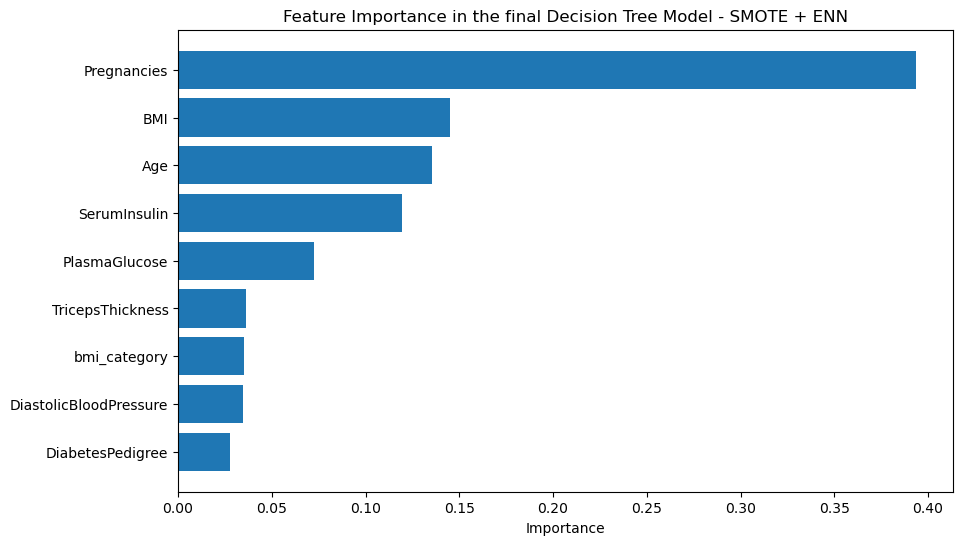

In [ ]:
# Decision Tree features importance score plot
dt_final1_importance = dt_final1.feature_importances_
dt_final1_feature = np.argsort(dt_final1_importance)

plt.figure(figsize = (10, 6))
plt.title("Feature Importance in the final Decision Tree Model - SMOTE + ENN")
plt.barh(range(X.shape[1]), dt_final1_importance[dt_final1_feature], align = "center")
plt.yticks(range(X.shape[1]), np.array(X.columns)[dt_final1_feature])
plt.xlabel("Importance")
plt.show()

### **5.1.8 Decision Tree - hyperparameter tuning for the ADASYN & TomekLinks adjusted sets**

In [145]:
# Model preparation and setup of Grid Search
dt_h2 = DecisionTreeClassifier(random_state = 0)
dt_h2_param_search = GridSearchCV(dt_h2, param_grid = dt_param_grid,
    scoring = "accuracy",
    cv = 5,
    n_jobs = 12)

dt_h2_param_search.fit(X_adatomek_train, y_adatomek_train)

dt_h2_best_parameters = dt_h2_param_search.best_params_

# Hyperparameter testing results (based on accuracy)
print("Best hyperparameters to choose: ", dt_h2_param_search.best_params_)

Best hyperparameters to choose:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'splitter': 'best'}


In [146]:
# Training our Random Forest using previously found parameters
dt_final2 = DecisionTreeClassifier(random_state = 0,
    criterion = dt_h2_best_parameters["criterion"],
    splitter = dt_h2_best_parameters["splitter"],
    max_depth = dt_h2_best_parameters["max_depth"],
    max_features = dt_h2_best_parameters["max_features"],
    min_samples_leaf = dt_h2_best_parameters["min_samples_leaf"],
    class_weight = dt_h2_best_parameters["class_weight"])

dt_final2.fit(X_adatomek_train, y_adatomek_train)

# Predictions
dt_final2_prediction = dt_final2.predict(X_test)
dt_final2_pima_prediction = dt_final2.predict(X_pima)

# Results
model_performance_metrics(y_test, dt_final2_prediction, y_pima, dt_final2_pima_prediction)

Classification Report - test dataset:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2000
           1       0.87      0.87      0.87      1000

    accuracy                           0.91      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.91      0.91      0.91      3000



Classification Report - PIMA Indian dataset:
              precision    recall  f1-score   support

           0       0.74      0.39      0.51       262
           1       0.37      0.72      0.49       130

    accuracy                           0.50       392
   macro avg       0.55      0.56      0.50       392
weighted avg       0.62      0.50      0.50       392



AUC-ROC score - test dataset: 0.90375


AUC-ROC score - PIMA Indian dataset: 0.55619


Confusion Matrix - test dataset:
[[1867  133]
 [ 126  874]]


Confusion Matrix - PIMA Indian dataset:
[[102 160]
 [ 36  94]]


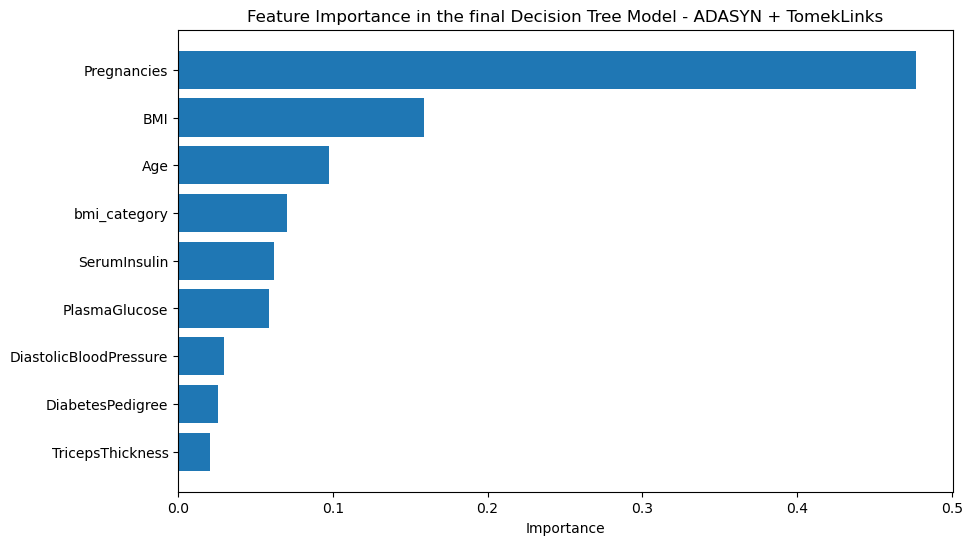

In [151]:
# Decision Tree features importance score plot
dt_final2_importance = dt_final2.feature_importances_
dt_final2_feature = np.argsort(dt_final2_importance)

plt.figure(figsize = (10, 6))
plt.title("Feature Importance in the final Decision Tree Model - ADASYN + TomekLinks")
plt.barh(range(X.shape[1]), dt_final2_importance[dt_final2_feature], align = "center")
plt.yticks(range(X.shape[1]), np.array(X.columns)[dt_final2_feature])
plt.xlabel("Importance")
plt.show()

---
---
---